 ## step1p3_mp.ipynb

This is a version of net_sim_mp.ipynb that is specialized for running parallel versions of step 1 part 3 with a different runner specification for each unit model.


By `Sergio Verduzco`  
July 2018

In [1]:
# import the ei_network class and draculab
%cd ..
from ei_network import *
from pathos.multiprocessing import ProcessingPool
import sys

/home/z/projects/draculab


In [2]:
# This is the name of the file where logging will happen
log_file = "./logs/mp_net" + time.strftime("_%m-%d-%y.txt")

In [3]:
%%capture capt 
# logging draculab version used for this session
print('#======================================================')
print('#             | Latest git commit: |')
print('#====================================================== \n#', end=' ')
!git log -1 --oneline --color=never

In [4]:
# Write the output of the cell above in the simulation log
f = open(log_file, mode='a')
f.write(capt.stdout)
f.close()

In [5]:
#~~~~~~~~~~~~ sig_trdc runner specification ~~~~~~~~~~~~

class s1p3_sig_trdc_runner():
    """ A class to run several ei_network objects, each in a different process."""
    def __init__(self):
        """ Set parameter values and build the networks. 
        
            Parameters set:
            name : a name that describes how this version of mp_net_runner is being used.
            n_procs : number of processes to use.
            n_nets : number of networks that will be created.
            n_pres : n_pres[i] = number of input presentations for net 'i'
            pres_t : pres_t[i] = duration of each presentation for net 'i'
            inp_pats : inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config.
            inp_funcs : inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
            inp_hist1 : inp_hist1[i] = list with ID's of the inputs presented by layer I1 of network 'i'. 
            inp_hist2 : inp_hist2[i] = list with ID's of the inputs presented by layer I2 of network 'i'. 
        """
        self.name = 's1p3_sig_trdc_test1'  # a name that describes the use
        self.code = '' # to place the source code in the mp_net_runner class (e.g. this cell)
        self.n_procs = 9  # one per network is good
        self.n_nets = 9
        self.n_pres = [300]*self.n_nets # n_pres[i] = number of input presentations for net 'i'
        self.pres_t = [1.]*self.n_nets # pres_t[i] = duration of each presentation for net 'i'
        self.inp_pats = [] # inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
        self.inp_funcs = [] # inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
        self.inp_hist1 = [[] for _ in range(self.n_nets)]  
        self.inp_hist2 = [[] for _ in range(self.n_nets)] 
        
        """
        # One way to continue simulations. Replace the rest of __init__() with this:
        #F = open("/media/z/DATA/pickles/mp_net_runner_prototype.pkl", 'rb')
        F = open("/home/z/projects/draculab/sig_trdc_test1.pkl", 'rb')
        dill_obj = dill.load(F)
        self.nets = dill_obj.nets
        F.close()
        del dill_obj 
        """
        
        layers =  ['L','I1', 'I2', 'I3', 'LI3']  
        # L is the layer, I1,I2,I3 are the input layers, LI3 is the layer between L and I3
        self.nets = [ei_network(layers, net_number=i) for i in range(self.n_nets)]
        
        # Setting the parameter changes for all networks
        ## First, set baseline changes
        for idx, net in enumerate(self.nets):
            net.annotate('This is network ' + str(idx) + ' in a run of an mp_net_runner object called ' + self.name)
            net.annotate('Based on the step1p2_07-20-18.txt and sig_trdc_test1.pkl it is testing networks of sig_trdc units,')
            net.annotate('with various LI3 configurations, trying to improve the fidelity with which LI3 represents I3 in step 1 part 3')
            #net.annotate('otherwise very good parameters from a simulation logged in step1p2_07/20/18.txt .')
            #net.annotate('10x10 in L.e and 5x5 in L.i without compensating. In here the radius of connection')
            #net.annotate('is increased, the standard tau_scale is decreased, and in the variations to the homeostatic ')
        #----------------------------------
            L = net.layers['L']
            I1 = net.layers['I1']
            I2 = net.layers['I2']
            I3 = net.layers['I3']
            LI3 = net.layers['LI3']
        #----------------------------------
            net.annotate('Configuration for sig_trdc in L.e')
            L.set_param('e_pars', 'type', unit_types.sig_trdc)
            L.set_param('e_pars', 'slope_min', 1.7)
            L.set_param('e_pars', 'slope_wid', .5)
            L.set_param('e_pars', 'thresh_min', 0.)
            L.set_param('e_pars', 'thresh_wid', 0.5)
            L.set_param('e_pars', 'tau_min', 0.1)
            L.set_param('e_pars', 'tau_wid', 0.3)
            L.set_param('e_pars', 'n_ports', 2)
            L.set_param('e_pars', 'branch_params', {'branch_w' : [0.3, 0.7], 'slopes' : 3, 'threshs' : 0.1})
            L.set_param('e_pars', 'tau_slow', 10.)
            L.set_param('e_pars', 'tau_fast', 0.05)
            L.set_param('e_pars', 'c', 3.)
            L.set_param('e_pars', 'tau_scale', .008)
            L.set_param('e_pars', 'tau_relax', 10.)
            L.set_param('e_pars', 'Kp', .02)
            L.set_param('e_pars', 'tau_thr', .01)
            L.set_param('e_pars', 'rdc_port', 0)
            L.set_param('e_pars', 'hr_port', 0)
            L.set_param('e_pars', 'thr_fix', 0.1)
            L.set_param('e_pars', 'tau_fix', 0.1)
            L.set_param('e_pars', 'sharpen_port', 2)
        #----------------------------------
            L.annotate("Adjusting size of e,i groups, and connection weights.")
            L.set_param('e_geom', 'rows', 10)
            L.set_param('e_geom', 'columns', 10)
            L.set_param('i_geom', 'rows', 5)
            L.set_param('i_geom', 'columns', 5)
            L.set_param('e_geom', 'jitter', 0.)
            L.set_param('i_geom', 'jitter', 0.)
            L.set_param('ee_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.3}})
            L.set_param('ei_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.3}})
            L.set_param('ie_conn', 'weights',{'uniform' : {'low': -1.2, 'high' : -.2}})
            L.set_param('ii_conn', 'weights',{'uniform' : {'low': -1., 'high' : -0.01}})
        #----------------------------------
            L.annotate("Setting local inputs for L")
            L.set_param('x_geom', 'rows', 0) # one or zero inputs in L, depending on sharpening
            L.set_param('x_geom', 'columns', 1)
            L.set_param('xe_conn', 'mask', {'circular': {'radius': 100.}}) # projecting to all L.e units
            L.set_param('xe_conn', 'kernel', 1.)
            L.set_param('xe_conn', 'weights', {'uniform' : {'low': 1., 'high': 1.}})
            L.set_param('xe_syn', 'inp_ports', L.e_pars['sharpen_port'])
            L.set_param('x_pars', 'tau_fast', 0.05)
        #-----------------------------------
            # specifying local input ports
            L.set_param('ee_syn', 'inp_ports', 0)
            L.set_param('ie_syn', 'inp_ports', 1)
        #----------------------------------
            L.annotate("Using Oja input synapses")
            L.set_param('xe_syn', 'type', synapse_types.oja)
            L.set_param('xe_syn', 'lrate', 1./100.)
            L.set_param('xi_syn', 'type', synapse_types.oja)
            L.set_param('xi_syn', 'lrate', 1./100.)
        #----------------------------------
            L.annotate("Using sq_hebbsnorm EE synapses")
            L.set_param('ee_syn', 'type', synapse_types.sq_hebbsnorm)
            L.set_param('ee_syn', 'lrate', 1./100.)
            L.set_param('ee_syn', 'omega', 1.8)
        #----------------------------------
            L.annotate("Using corr_homeo_inhib IE synapses")
            L.set_param('ie_syn', 'type', synapse_types.corr_inh)
            L.set_param('ie_syn', 'lrate', 1./40.)
            L.set_param('ie_syn', 'des_act', 0.3)
        #----------------------------------
            L.annotate("Using static EI synapses")
            L.set_param('ei_syn', 'type', synapse_types.static)
        #----------------------------------
            I1.annotate("Configuration of I1 geometry")
            I1.set_param('e_geom', 'rows', 0)
            I1.set_param('i_geom', 'rows', 0)
            I1.set_param('x_geom', 'rows', 10)
            I1.set_param('x_geom', 'columns', 1)
            I1.set_param('x_geom', 'extent', [.5, 1.])
            I1.set_param('x_geom', 'center', [-.7, 0.])
        #----------------------------------
            I2.annotate("Configuration of I2 geometry")
            I2.set_param('e_geom', 'rows', 0)
            I2.set_param('i_geom', 'rows', 0)
            I2.set_param('x_geom', 'rows', 1)
            I2.set_param('x_geom', 'columns', 10)
            I2.set_param('x_geom', 'extent', [1., .5])
            I2.set_param('x_geom', 'center', [0., .7])
        #----------------------------------
            I3.annotate("Configuration of I3 geometry")
            I3.set_param('e_geom', 'rows', 0)
            I3.set_param('i_geom', 'rows', 0)
            I3.set_param('x_geom', 'rows', 1)
            I3.set_param('x_geom', 'columns', 10)
            I3.set_param('x_geom', 'extent', [1., .5])
            I3.set_param('x_geom', 'center', [0., -.9])
        #----------------------------------
            L.set_param('n', 'w_track', 16)
            LI3.set_param('n', 'w_track', 8)
            I1.set_param('n', 'w_track', 0)
            I2.set_param('n', 'w_track', 0)
            I3.set_param('n', 'w_track', 0)
        #----------------------------------
        # Layer LI3 parameters
        #----------------------------------
            LI3.annotate("Configuration of units in layer LI3.")
            LI3.set_param('e_pars', 'type', unit_types.sig_trdc)
            LI3.set_param('e_pars', 'slope_min', 1.9)
            LI3.set_param('e_pars', 'slope_wid', .2)
            LI3.set_param('e_pars', 'thresh_min', 0.2)
            LI3.set_param('e_pars', 'thresh_wid', 0.5)
            LI3.set_param('e_pars', 'tau_min', 0.1)
            LI3.set_param('e_pars', 'tau_wid', 0.3)
            LI3.set_param('e_pars', 'n_ports', 2)
            LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.3, 0.7], 'slopes' : 3, 'threshs' : 0.1})
            LI3.set_param('e_pars', 'tau_slow', 10.)
            LI3.set_param('e_pars', 'tau_fast', 0.05)
            LI3.set_param('e_pars', 'c', 2.)
            LI3.set_param('e_pars', 'tau_scale', .05)
            LI3.set_param('e_pars', 'tau_relax', 10.)
            LI3.set_param('e_pars', 'Kp', .02)
            LI3.set_param('e_pars', 'tau_thr', .01)
            LI3.set_param('e_pars', 'rdc_port', 0)
            LI3.set_param('e_pars', 'hr_port', 0)
            LI3.set_param('e_pars', 'thr_fix', 0.1)
            LI3.set_param('e_pars', 'tau_fix', 0.1)
            LI3.set_param('e_pars', 'sharpen_port', 2)
        #----------------------------------
            LI3.annotate("Adjusting e,i groups, and configuring EI,IE connections")
            LI3.set_param('e_geom', 'rows', 1)
            LI3.set_param('e_geom', 'columns', 10)
            LI3.set_param('i_geom', 'rows', 1)
            LI3.set_param('i_geom', 'columns', 5)
            LI3.set_param('e_geom', 'jitter', 0.)
            LI3.set_param('i_geom', 'jitter', 0.)
            LI3.set_param('e_geom', 'extent', [1., .5])
            LI3.set_param('e_geom', 'center', [0., -.7])
            LI3.set_param('i_geom', 'extent', [1., .5])
            LI3.set_param('i_geom', 'center', [0., -.7])
            LI3.set_param('x_geom', 'extent', [1., .5])
            LI3.set_param('x_geom', 'center', [0., -.7])

            LI3.set_param('ee_conn', 'mask', {'circular' : {'radius': 3.}})
            LI3.set_param('ee_conn', 'kernel', {'gaussian' : {'p_center' : 1.1, 'sigma' : .5}})
            LI3.set_param('ee_conn', 'allow_autapses', True)
            LI3.set_param('ee_conn', 'weights', {'gaussian' : {'w_center' : .5, 'sigma' : .2}})

            LI3.set_param('ei_conn', 'mask', {'annular' : {'inner_radius': .2, 'outer_radius' : 0.5}})
            LI3.set_param('ei_conn', 'kernel', 1.)
            LI3.set_param('ei_conn', 'weights',{'ring_gaussian' : {'w_center' : .8, 'sigma' : .2, 'radius' : .3}})

            LI3.set_param('ie_conn', 'mask', {'circular' : {'radius': 3.}})
            LI3.set_param('ie_conn', 'kernel', {'gaussian' : {'p_center' : 1., 'sigma' : 2.}})
            LI3.set_param('ie_conn', 'allow_autapses', True)
            LI3.set_param('ie_conn', 'weights', {'gaussian' : {'w_center' : -.8, 'sigma' : .5}})

            LI3.set_param('ii_conn', 'weights',{'uniform' : {'low': -.5, 'high' : -0.2}})
        #----------------------------------
            LI3.annotate("Setting LI3.x configuration")
            LI3.set_param('x_geom', 'rows', 0) # one or zero inputs in L, depending on sharpening
            LI3.set_param('x_geom', 'columns', 0)
            LI3.set_param('xe_conn', 'mask', {'circular': {'radius': 100.}}) # projecting to all LI3.e units
            LI3.set_param('xe_conn', 'kernel', 1.)
            LI3.set_param('xe_conn', 'weights', {'uniform' : {'low': 1., 'high': 1.}})
            LI3.set_param('xe_syn', 'inp_ports', L.e_pars['sharpen_port'])
        #-----------------------------------
        # specifying local input ports
            LI3.set_param('ee_syn', 'inp_ports', 0)
            LI3.set_param('ie_syn', 'inp_ports', 1)
        #----------------------------------
            LI3.annotate("Using static input synapses")
            LI3.set_param('xe_syn', 'type', synapse_types.static)
            LI3.set_param('xi_syn', 'type', synapse_types.static)
        #----------------------------------
            LI3.annotate("Using sq_hebbsnorm EE synapses")
            LI3.set_param('ee_syn', 'type', synapse_types.sq_hebbsnorm)
            LI3.set_param('ee_syn', 'lrate', 1./100.)
            LI3.set_param('ee_syn', 'omega', 1.5)
        #----------------------------------
            LI3.annotate("Using static IE synapses")
            LI3.set_param('ie_syn', 'type', synapse_types.static)
        #----------------------------------
            LI3.annotate("Using anticov EI synapses")
            LI3.set_param('ei_syn', 'type', synapse_types.anticov)
            LI3.set_param('ei_syn', 'lrate', 1./500.)
        #----------------------------------
        # Add interlayer connections
            net.add_connection(('I1','x'), ('L','e'))
            net.add_connection(('I1','x'), ('L','i'))
            net.add_connection(('I2','x'), ('L','e'))
            net.add_connection(('I2','x'), ('L','i'))
            net.add_connection(('I3','x'), ('LI3','e'))
            net.add_connection(('I3','x'), ('LI3','i'))
            net.add_connection(('LI3','e'), ('L','e'))
            net.add_connection(('LI3','e'), ('L','i'))
            net.add_connection(('L','e'), ('LI3','e'))
        #----------------------------------        
        # Configure interlayer connections
            net.set_param('I1x_Le_conn', 'connection_type', 'convergent')
            net.set_param('I1x_Le_conn', 'number_of_connections', 2)
            net.set_param('I1x_Le_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I1x_Le_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I1x_Le_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : .9}})
            net.set_param('I1x_Le_conn', 'dist_dim', 'y')
            net.set_param('I1x_Le_conn', 'edge_wrap', True)
            net.set_param('I1x_Le_syn', 'inp_ports', 1)
            net.set_param('I1x_Le_syn', 'type', synapse_types.bcm)
            net.set_param('I1x_Le_syn', 'lrate', 1./50.)
            net.set_param('I1x_Le_syn', 'omega', 1.5)

            net.set_param('I1x_Li_conn', 'connection_type', 'convergent')
            net.set_param('I1x_Li_conn', 'number_of_connections', 2)
            net.set_param('I1x_Li_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I1x_Li_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I1x_Li_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : 0.5}})
            net.set_param('I1x_Li_conn', 'dist_dim', 'y')
            net.set_param('I1x_Li_conn', 'edge_wrap', True)

            net.set_param('I2x_Le_conn', 'connection_type', 'convergent')
            net.set_param('I2x_Le_conn', 'number_of_connections', 2)
            net.set_param('I2x_Le_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I2x_Le_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I2x_Le_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : .9}})
            net.set_param('I2x_Le_conn', 'dist_dim', 'x')
            net.set_param('I2x_Le_conn', 'edge_wrap', True)
            net.set_param('I2x_Le_syn', 'inp_ports', 1)
            net.set_param('I2x_Le_syn', 'type', synapse_types.bcm)
            net.set_param('I2x_Le_syn', 'lrate', 1./50.)
            net.set_param('I2x_Le_syn', 'omega', 1.5)

            net.set_param('I2x_Li_conn', 'connection_type', 'convergent')
            net.set_param('I2x_Li_conn', 'number_of_connections', 2)
            net.set_param('I2x_Li_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I2x_Li_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I2x_Li_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : 0.5}})
            net.set_param('I2x_Li_conn', 'dist_dim', 'x')
            net.set_param('I2x_Li_conn', 'edge_wrap', True)

            net.set_param('I3x_LI3e_conn', 'mask', {'circular': {'radius': .2}})
            net.set_param('I3x_LI3e_conn', 'kernel', 1.)
            net.set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 2., 'sigma' : .2}})
            net.set_param('I3x_LI3e_conn', 'dist_dim', 'x')
            net.set_param('I3x_LI3e_conn', 'edge_wrap', True)
            net.set_param('I3x_LI3e_syn', 'inp_ports', 1)
            net.set_param('I3x_LI3e_syn', 'type', synapse_types.static)

            net.set_param('I3x_LI3i_conn', 'mask', {'annular' : {'inner_radius': .1, 'outer_radius' : 0.5}})
            net.set_param('I3x_LI3i_conn', 'kernel', 1.)
            net.set_param('I3x_LI3i_conn', 'weights', {'ring_gaussian' : {'w_center' : .8, 'sigma' : .3, 'radius' : .2}})
            net.set_param('I3x_LI3i_conn', 'dist_dim', 'x')
            net.set_param('I3x_LI3i_conn', 'edge_wrap', True)

            net.set_param('LI3e_Le_conn', 'connection_type', 'convergent')
            net.set_param('LI3e_Le_conn', 'number_of_connections', 2)
            net.set_param('LI3e_Le_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('LI3e_Le_conn', 'kernel', .4)
            net.set_param('LI3e_Le_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : .9}})
            net.set_param('LI3e_Le_conn', 'edge_wrap', True)
            net.set_param('LI3e_Le_syn', 'inp_ports', 1)
            net.set_param('LI3e_Le_syn', 'type', synapse_types.bcm)
            net.set_param('LI3e_Le_syn', 'lrate', 1./50.)
            net.set_param('LI3e_Le_syn', 'omega', 1.5)

            net.set_param('LI3e_Li_conn', 'connection_type', 'convergent')
            net.set_param('LI3e_Li_conn', 'number_of_connections', 2)
            net.set_param('LI3e_Li_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('LI3e_Li_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('LI3e_Li_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : .5}})
            net.set_param('LI3e_Li_conn', 'dist_dim', 'x')
            net.set_param('LI3e_Li_conn', 'edge_wrap', True)

            net.set_param('Le_LI3e_conn', 'connection_type', 'divergent')
            net.set_param('Le_LI3e_conn', 'number_of_connections', 6)
            net.set_param('Le_LI3e_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('Le_LI3e_conn', 'kernel', 1.)
            net.set_param('Le_LI3e_conn', 'weights', {'uniform' : {'low' : 0.01, 'high' : .02}})
            net.set_param('Le_LI3e_conn', 'edge_wrap', True)
            net.set_param('Le_LI3e_conn', 'boundary', {'center':L.e_geom['center'], 'extent':L.e_geom['extent']})
            net.set_param('Le_LI3e_syn', 'inp_ports', 1)
            net.set_param('Le_LI3e_syn', 'type', synapse_types.sq_hebbsnorm)
            net.set_param('Le_LI3e_syn', 'lrate', 1./50.)
            net.set_param('Le_LI3e_syn', 'omega', 1.) # for sq_hebbsnorm
          
        
        # Now adjust networks individually
        ### network 0 is the baseline
        ### network 1
        n = 1
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using ds LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.double_sigma)
        LI3.set_param('e_pars', 'slope_min', 8)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', -0.1)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 3)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.3, 0.4, 0.3], 'slopes' : 3, 'threshs' : 0.})
        LI3.set_param('ie_conn', 'kernel', {'gaussian' : {'p_center' : 1., 'sigma' : 1.8}})
        LI3.set_param('ie_conn', 'weights', {'gaussian' : {'w_center' : -.9, 'sigma' : .6}})
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)    
        ### network 2
        n = 2
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using sds LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.sigma_double_sigma)
        LI3.set_param('e_pars', 'slope_min', 8)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 3)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.4, 0.6], 'slopes' : 4, 'threshs' : 0.3})
        LI3.set_param('ee_syn', 'inp_ports', 1)  # This is the key
        LI3.set_param('ee_syn', 'omega', .5)
        LI3.annotate("Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.3)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 1.5, 'sigma' : .1}})
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 0)  # This is the key
        #self.nets[n].set_param('I3x_LI3i_conn', 'weights', {'ring_gaussian' : {'w_center' : .4, 'sigma' : .3, 'radius' : .2}})
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        self.nets[n].set_param('Le_LI3e_syn', 'omega', 1.5) # for sq_hebbsnorm
        ### network 3
        n = 3
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using sds_trdc LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.sds_trdc)
        LI3.set_param('e_pars', 'slope_min', 8)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 3)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.4, 0.6], 'slopes' : 4, 'threshs' : 0.3})
        LI3.set_param('e_pars', 'rdc_port', 1)  # only difference with n=2
        LI3.set_param('ee_syn', 'inp_ports', 1)  # This is the key
        LI3.set_param('ee_syn', 'omega', .5)
        LI3.annotate("Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.3)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 1.5, 'sigma' : .1}})
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 0)  # This is the key
        #self.nets[n].set_param('I3x_LI3i_conn', 'weights', {'ring_gaussian' : {'w_center' : .4, 'sigma' : .3, 'radius' : .2}})
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        ### Network 4
        n = 4
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using sds_sharp LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.sds_sharp)
        LI3.set_param('e_pars', 'slope_min', 8)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 4)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.4, 0.6], 'slopes' : 4, 'threshs' : 0.3})
        LI3.set_param('e_pars', 'rdc_port', 1) 
        LI3.set_param('e_pars', 'thr_fix', 0.)
        LI3.set_param('ee_syn', 'inp_ports', 1) 
        LI3.set_param('ee_syn', 'omega', .5)
        LI3.annotate("Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.3)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 1.5, 'sigma' : .1}})
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 0)  
        #self.nets[n].set_param('I3x_LI3i_conn', 'weights', {'ring_gaussian' : {'w_center' : .4, 'sigma' : .3, 'radius' : .2}})
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        LI3.set_param('x_geom', 'rows', 1) # one input in LI3
        LI3.set_param('x_geom', 'columns', 1)
        LI3.set_param('xe_syn', 'inp_ports', LI3.e_pars['sharpen_port'])
        LI3.set_param('x_pars', 'tau_fast', 0.05)
        ### Network 5
        n = 5
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using double_sigma_n LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.double_sigma_n)
        LI3.set_param('e_pars', 'slope_min', 13)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.1)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 3)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.1, 0.6, .3], 'slopes' : 4, 'threshs' : 0.2})
        LI3.set_param('e_pars', 'phi', 0.4)
        LI3.set_param('ie_conn', 'kernel', {'gaussian' : {'p_center' : 1., 'sigma' : 1.8}})
        LI3.set_param('ie_syn', 'inp_ports', 0)
        LI3.set_param('ee_syn', 'omega', 1.8)
        #self.nets[n].set_param('I3x_LI3i_conn', 'weights', {'ring_gaussian' : {'w_center' : .4, 'sigma' : .3, 'radius' : .2}})
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        ### Network 6
        n = 6
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using sds_n LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.sds_n)  # same parameters as sds...
        LI3.set_param('e_pars', 'slope_min', 8)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 3)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.4, 0.6], 'slopes' : 4, 'threshs' : 0.3})
        LI3.set_param('ee_syn', 'inp_ports', 1)  # This is the key
        LI3.set_param('ee_syn', 'omega', .5)
        LI3.annotate("Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.3)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 1.5, 'sigma' : .1}})
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 0)  # This is the key
        #self.nets[n].set_param('I3x_LI3i_conn', 'weights', {'ring_gaussian' : {'w_center' : .4, 'sigma' : .3, 'radius' : .2}})
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        self.nets[n].set_param('Le_LI3e_syn', 'omega', 1.5) # for sq_hebbsnorm
        ### Network 7
        n = 7
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using sds_n_sharp LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.sds_n_sharp)  # same parameters as sds_sharp
        LI3.set_param('e_pars', 'slope_min', 8)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 4)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.4, 0.6], 'slopes' : 4, 'threshs' : 0.3})
        LI3.set_param('e_pars', 'rdc_port', 1) 
        LI3.set_param('e_pars', 'thr_fix', 0.)
        LI3.set_param('ee_syn', 'inp_ports', 1) 
        LI3.set_param('ee_syn', 'omega', .5)
        LI3.annotate("Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.3)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 1.5, 'sigma' : .1}})
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 0)  
        #self.nets[n].set_param('I3x_LI3i_conn', 'weights', {'ring_gaussian' : {'w_center' : .4, 'sigma' : .3, 'radius' : .2}})
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        LI3.set_param('x_geom', 'rows', 1) # one input in LI3
        LI3.set_param('x_geom', 'columns', 1)
        LI3.set_param('xe_syn', 'inp_ports', LI3.e_pars['sharpen_port'])
        LI3.set_param('x_pars', 'tau_fast', 0.05)
        ### Network 8
        n = 8
        LI3 = self.nets[n].layers['LI3'] 
        LI3.annotate(">>> Using ds_ssrdc_sharp LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.ds_ssrdc_sharp)
        LI3.set_param('e_pars', 'slope_min', 6)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.1)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 4)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.2, 0.5, .3], 'slopes' : 4, 'threshs' : 0.})
        LI3.set_param('e_pars', 'tau_scale', .05)
        LI3.set_param('e_pars', 'tau_relax', 5.)
        LI3.set_param('e_pars', 'Kp', .02)
        LI3.set_param('e_pars', 'rdc_port', 0)
        LI3.set_param('e_pars', 'sharpen_port', 3)
        LI3.set_param('ie_syn', 'inp_ports', 1)
        LI3.set_param('x_geom', 'rows', 1) # one input in LI3
        LI3.set_param('x_geom', 'columns', 1)
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 2., 'sigma' : .1}})
        LI3.set_param('ie_syn', 'inp_ports', 1) # sneaky, effective, inhibition goes to strong branch
        #self.nets[n].set_param('I3x_LI3i_conn', 'weights', {'ring_gaussian' : {'w_center' : .4, 'sigma' : .3, 'radius' : .2}})
        
        self.build()
                   
            
    def build(self):
        # Building the networks
        # The point of putting this outside the __init__ method is that if at some point the networks get too
        # big and take a long time to build, you can build them in parallel by creating a build(net_num)
        # method and then calling it from run_all with pool.map(build, range(self.n_nets))
        for net in self.nets:
            net.build()
         
    def inp_pat1(self, pres, n_pat1, n_pat2, random=True):
        """ A function to create input patterns for I1. """
        if random:  
            idx = self.input_list[pres][0]
        else:
            idx = int( np.floor( (pres%(n_pat1*n_pat2)/n_pat2) )  )
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat1)) for x in range(n_pat1)], idx)

    def inp_pat2(self, pres, n_pat1, n_pat2, random=True):
        """ A function to create input patterns for I2. """
        if random:  
            idx = self.input_list[pres][1]
        else:
            mpres = pres%(n_pat1*n_pat2)
            idx = int( np.round( ( mpres % n_pat2) )  )
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat1)) for x in range(n_pat1)], idx)
    
    def I3_fun(self, I1, I2, n_pat3):
        """ The function that produces the I3 input pattern from the I1 and I2 input patterns. """
        return (I1 + I2)%n_pat3
    
    def inp_pat3(self, pres, n_pat1, n_pat2, n_pat3, random=True):
        """ A function to create input patterns for I3. """
        if random:  
            idx = self.input_list[pres][2]
        else:
            mpres = pres%(n_pat1*n_pat2)
            idx = int( self.I3_fun(np.round(mpres % n_pat2), np.floor(mpres / n_pat2), n_pat3) )
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat1)) for x in range(n_pat1)], idx)

    def make_I1_inp(self, n_pat1, n_pat2, net_id, rnd):
        """ Returns a function that is a specific version of self.inp_pat1 suited of the 'net_id' net. """
        if hasattr(self.nets[net_id], 'present'): # if this network has been run before
            past = self.nets[net_id].present
        else:
            past = 0
        # the presentation number is pres-past to avoid bad indexes in self.input_list
        return lambda pres, rows, columns, n_id: self.inp_pat1(pres-past, n_pat1, n_pat2, random=rnd) 
    
    def make_I2_inp(self, n_pat1, n_pat2, net_id, rnd):
        """ Returns a function that is a specific version of self.inp_pat2 suited of the 'net_id' net. """
        if hasattr(self.nets[net_id], 'present'):  # if this network has been run before
            past = self.nets[net_id].present
        else:
            past = 0
        return lambda pres, rows, columns, n_id: self.inp_pat2(pres-past, n_pat1, n_pat2, random=rnd) 
    
    def make_I3_inp(self, n_pat1, n_pat2, n_pat3, net_id, rnd):
        """ Returns a function that is a specific version of self.inp_pat3 suited of the 'net_id' net. """
        if hasattr(self.nets[net_id], 'present'):  # if this network has been run before
            past = self.nets[net_id].present
        else:
            past = 0
        return lambda pres, rows, columns, n_id: self.inp_pat3(pres-past, n_pat1, n_pat2, n_pat3, random=rnd) 

    def make_shrp_fun(self, prev_pat, cur_pat, init_time, pres_time):
        """ Returns a function that goes from 1 to 0 when its argument is close to init_time or init_time+pres_time.
            
            Args:
                prev_pat : 1-D numpy array with the previous input pattern. (not currently used)
                cur_pat : 1-D numpy array with the current input pattern. (not currently used)
                init_time: initial time of this presentation.
                pres_time: duration of this presentation.
        """
        eps = .1 # distance to the input change where sharpening is released
        return lambda t : 0. if (t < init_time+eps or t > init_time+pres_time-eps) else 1.
    
    def set_shrp_fun(self, pre_inp, cur_inp, init_time, pres_time, inp_units):
        """ Sets the sharpening function on the given input units using make_shrp_fun. """
        for unit in inp_units:
            unit.set_function( self.make_shrp_fun(pre_inp, cur_inp, init_time, pres_time) )
            
    def input_config(self):
        """ Populates the self.inp_pats, and self.inp_funcs lists used by run_net() to provide inputs.
        
            inp_pats[i] is the set_inp_pat dictionary given as an argument to ei_network.run for the i-th network.
            inp_funcs[i] is the set_inp_fun dictionary given as an argument to ei_network.run for the i-th network.
        """  
        # Generate input pattern list for I layers
        self.input_list = [] # will contain 3-tuples with all the input indexes (I1x,I2x,I3x)        
        nprs = max(self.n_pres) # how many input patterns to generate
        np1 = self.nets[0].layers['I1'].n['x'] # assuming all networks have same input geometry!!!
        np2 = self.nets[0].layers['I2'].n['x']
        np3 = self.nets[0].layers['I3'].n['x']
        n_inp = np1*np2
        for epoch in range(int(np.floor(nprs/n_inp))): # we present all patterns in one full epoch
            aux_list = []
            for p1 in range(np1):
                for p2 in range(np2):
                    aux_list.append( (p1, p2, self.I3_fun(p1,p2,np3)) ) 
            np.random.shuffle(aux_list)
            self.input_list += aux_list
        rem_inps = int(np.round(nprs%n_inp)) # inputs constituting just part of an epoch
        pat_ids = np.random.choice(range(n_inp), rem_inps, replace=False)
        for pid in pat_ids:
            p1 = int(np.floor(pid/np2))
            p2 = int(round(pid%np2))
            self.input_list.append( ( p1, p2, self.I3_fun(p1,p2,np3) ) ) 
        # Create input pattern dictionaries and append them to the lists
        for idx, net in enumerate(self.nets):
            #L = net.layers['L']
            I1 = net.layers['I1']
            I2 = net.layers['I2']
            I3 = net.layers['I3']
            n_pat1 = I1.n['x']  # number of input patterns for I1 is number of input units
            n_pat2 = I2.n['x']  # number of input patterns for I2 is number of input units     
            n_pat3 = I3.n['x']  # number of input patterns for I3 is number of input units     
            shrp_inp_pat = lambda p, r, c, n : (1., 1)
            inp_pat_dic = { 'I1' : self.make_I1_inp(n_pat1, n_pat2, idx, True), 
                            'I2' : self.make_I2_inp(n_pat1, n_pat2, idx, True), 
                            'I3' : self.make_I3_inp(n_pat1, n_pat2, n_pat3, idx, True),
                            'L' : shrp_inp_pat,
                            'LI3' : shrp_inp_pat }
            inp_fun_dic = {'L' : self.set_shrp_fun,
                           'LI3' : self.set_shrp_fun }
            self.inp_pats.append(inp_pat_dic)
            self.inp_funcs.append(inp_fun_dic)

    def nullify_I3(self):
        """ Nullifies the I3-LI3 connections in all networks. """
        for net in self.nets:
            for syn_list in [net.net.syns[idx] for idx in net.layers['LI3'].e]:
                for syn in syn_list:
                    if syn.preID in net.layers['I3'].x:
                        syn.w = 0.
                        
    def run_net(self, arg):
        net_num = arg[0]
        n_pres = arg[1]
        if n_pres > 0:
            print('Running network %d' % (net_num))
            return self.nets[net_num].run(n_pres, self.pres_t[net_num], self.inp_pats[net_num], self.inp_funcs[net_num])
        else: 
            return self.nets[net_num]
        
    def run_all(self, save=False, log=False, save_interv=10, pool=None):
        sys.setrecursionlimit(5000)  # otherwise the networks can't be pickled
        if pool == None:
            pool = ProcessingPool(nodes=self.n_procs) 
        self.input_config()  # configures the input functions
        print('Starting %d processes, %d networks' % (self.n_procs, self.n_nets))
        start_time = time.time()
        if save:
            run_sched = [ [] for _ in range(self.n_nets) ] # run_sched[i][j] = number of presentations in the j-th run
                                                           # of network i
            for idx in range(self.n_nets):
                base = int(np.floor(self.n_pres[idx]/save_interv))
                run_sched[idx] = [save_interv]*base 
                remainder = self.n_pres[idx]%save_interv
                if remainder > 0:
                    run_sched[idx].append(remainder)
            self.max_runs = max([len(sch) for sch in run_sched])
            run_sched = [sch + [0]*(self.max_runs-len(sch)) for sch in run_sched]
                    
            for run in range(self.max_runs):
                args = [(n, run_sched[n][run]) for n in range(self.n_nets)]
                self.nets = pool.map(self.run_net, args)
                for net in self.nets:
                    net.history.append('ei_network backup after run ' + str(run) + ' of mp_net_runner object ' + self.name)
                print("<><><><><> Backing up simulation after run " + str(run))
                F = open(self.name+'.pkl', 'wb')
                dill.dump(self, F)
                F.close()
        else:
            args = [(n, self.n_pres[n]) for n in range(n_nets)]
            self.nets = pool.map(self.run_net, args)
                
        print('****** Processing finished after %s seconds ******' % (time.time() - start_time)) 
        pool.close()
        pool.join()
        
        if log:
            self.log()
                
    def log(self, file_name=log_file):
        for net in self.nets:
            net.log(file_name, params=(net.net_number == 0))                                                                
            
    def io_compare(self, net_num=0):
        """ Simple analysis of the relation between inputs and outputs."""
        net = self.nets[net_num]
        pats1 = net.inp_hist['I1']
        pats2 = net.inp_hist['I2']
        n_pat1 = net.layers['I1'].n['x']
        n_pat2 = net.layers['I2'].n['x']
        n_pats = n_pat1*n_pat2
        pres_time = self.pres_t[net_num]
        n_pres = self.nets[net_num].present
        L = net.layers['L']
        inp_pat1 = self.make_I1_inp(n_pat1, n_pat2, net_num, False)
        inp_pat2 = self.make_I2_inp(n_pat1, n_pat2, net_num, False)

        ## For each input presentation obtain the activity vector from layer L (e_pats)
        ppat = int(round(pres_time/net.net_params['min_delay'])) # number of data points per input pattern
        pt = int(round((pres_time-0.2)/net.net_params['min_delay'])) # data point where the vector will come from
        e_pats = np.zeros((len(L.e), n_pres))  # array where we'll store the activity vectors
        for pres in range(n_pres):
            for e_idx, idx in enumerate(L.e):
                e_pats[e_idx, pres] = net.all_activs[idx, pres*ppat + pt]

        ## Obtain the ID of the pattern that appeared at each input presentation (pres_pat)
        pres_pat = [ i[0]*n_pat2 + i[1] for i in self.input_list ]
        
        ## get the mean of output patterns corresponding to the same inputs (mean_out)
        mean_out = np.zeros((len(L.e),n_pats)) # mean_out[:,n] = mean output for input n
        pat_reps = np.zeros(n_pats) # pat_reps[n] = number of times the pattern with ID 'n' appeared
        for pres in range(n_pres):
            mean_out[:, int(pres_pat[pres])] += e_pats[:,pres]
            pat_reps[pres_pat[pres]] += 1
        for pat in range(n_pats):
            if pat_reps[pat] > 1:
                mean_out[:, pat] = mean_out[:, pat] / pat_reps[pat]
        
        ## Obtain the dot products between any two pairs of input (inp_dots) or output (out_dots) patterns
        # get all input patterns
        all_inps = np.zeros((n_pats, n_pat1+n_pat2)) # all_inps[n,:] = input pattern with ID 'n'
        for p1 in range(n_pat1):
            for p2 in range(n_pat2):
                idx = p1*n_pat2+p2
                (all_inps[idx, :n_pat1], _) = inp_pat1(idx, 1, 1, net_num)
                (all_inps[idx, n_pat1:], _) = inp_pat2(idx, 1, 1, net_num)     
        # get matrices with dot products between pairs of patterns
        inp_norm = np.linalg.norm(all_inps[0,:])   # all input vectors have the same norm
        inp_norm2 = inp_norm*inp_norm
        inp_dots = np.zeros((n_pats, n_pats))
        out_dots = np.zeros((n_pats, n_pats))
        for p1 in range(n_pats):
            for p2 in range(n_pats):
                inp_dots[p1,p2] = np.dot(all_inps[p1,:], all_inps[p2,:])/inp_norm2
                if pat_reps[p1] > 0 and pat_reps[p2] > 0: # if the two input patterns were presented
                    vec1 = mean_out[:,p1]
                    vec2 = mean_out[:,p2]
                    norm1 = np.linalg.norm(vec1)
                    norm2 = np.linalg.norm(vec2)
                    out_dots[p1,p2] = np.dot(vec1,vec2)/(norm1*norm2)
                
        # compare the angles between input patterns with the angles between output patterns
        absissae = []
        ordinates = []
        for row in range(n_pats):
            for column in range(n_pats):
                if out_dots[row,column] > 0:
                    absissae.append(inp_dots[row,column])
                    ordinates.append(out_dots[row,column])
            
        #plot the results of the analysis
        %matplotlib inline
        fig, axes = plt.subplots(2,2, figsize=(21, 23))
        fig.subplots_adjust(hspace=0.2, wspace=0.1)

        im0 = axes[0,0].plot(absissae, ordinates, '.')
        axes[0,0].set_title('inp_dots vs out_dots')
        im1 = axes[0,1].imshow(mean_out)
        axes[0,1].set_title('mean output for each input pattern')
        axes[0,1].set_xlabel('input ID')
        fig.colorbar(im1,ax=axes[0,1],fraction=0.1,shrink=0.8)
        im2 = axes[1,0].imshow(inp_dots)
        axes[1,0].set_title('dot products between input vectors')
        im3 = axes[1,1].imshow(out_dots)
        axes[1,1].set_title('dot products between mean output vectors')
        #fig.colorbar(im3,fraction=0.1,shrink=0.8)

        # plot the array of activity patterns
        ex_fig = plt.figure(figsize=(20,10))
        plt.imshow(e_pats)
    
        # A numerical measure of how much the output representation differentiates the inputs may be the norm of (inp_dots - out_dots)
        diff_norm = np.linalg.norm(inp_dots-out_dots) # will use Frobenius norm, as if they were vectors
        print("norm of output matrix: %f" % (np.linalg.norm(out_dots)))
        print("norm of input matrix: %f" % (np.linalg.norm(inp_dots)))
        print("norm of difference between matrices: %f" % (diff_norm))                        

    def I3_LI3_compare(self, start_time):
        """ Compare the activities of I3 and LI3 from start_time onwards. """
        pass
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [6]:
%%capture runner
# capture the configuration of the mp_net_runner object
%history -l 1

In [7]:
# Create an mp_net_runner object and simulate
## Create
mp_net_obj = s1p3_sig_trdc_runner()
## Put the code that configures mp_net_runner in mp_net_obj.code
mp_net_obj.code = str(runner)
## nullify the I3 inputs
#mp_net_obj.nullify_I3()
## Run
mp_net_obj.run_all(save=True, log=False, save_interv=10)

Building layer I2 at network 0
Building layer I1 at network 0
Building layer LI3 at network 0
Building layer L at network 0


/home/z/projects/draculab/topology.py:286: UserWarning: topo_connect received an empty list as an argument
  warn('topo_connect received an empty list as an argument', UserWarning)


Building layer I3 at network 0


Creating I1x_Le connection at network 0
Creating I1x_Li connection at network 0
Creating I2x_Le connection at network 0
Creating I2x_Li connection at network 0
Creating I3x_LI3e connection at network 0
Creating I3x_LI3i connection at network 0
Creating LI3e_Le connection at network 0
Creating LI3e_Li connection at network 0
Creating Le_LI3e connection at network 0
Building layer I2 at network 1
Building layer I1 at network 1
Building layer LI3 at network 1
Building layer L at network 1
Building layer I3 at network 1


Creating I1x_Le connection at network 1
Creating I1x_Li connection at network 1
Creating I2x_Le connection at network 1
Creating I2x_Li connection at network 1
Creating I3x_LI3e connection at network 1
Creating I3x_LI3i connection at network 1
Creating LI3e_Le connection at network 1
Creating LI3e_Li connection at network 1
Creating Le_LI3e connection at network 1
Building layer I2 at network 2
Building layer I1 at network 2
Building layer

/home/z/projects/draculab/units.py:3148: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-slope*(arg - thresh)))


Presentation 2 took 15.772335529327393 seconds  at network 0
Starting presentation 3 at network 0
Presentation 1 took 15.854103803634644 seconds  at network 3
Starting presentation 2 at network 3
Presentation 0 took 16.110065460205078 seconds  at network 6
Starting presentation 1 at network 6
Presentation 2 took 15.409241914749146 seconds  at network 1
Starting presentation 3 at network 1
Presentation 1 took 15.809279203414917 seconds  at network 4
Starting presentation 2 at network 4
Presentation 0 took 16.621140241622925 seconds  at network 7
Starting presentation 1 at network 7
Presentation 2 took 16.384952783584595 seconds  at network 2
Starting presentation 3 at network 2
Presentation 1 took 15.982622146606445 seconds  at network 5
Starting presentation 2 at network 5
Presentation 0 took 18.22710943222046 seconds  at network 8
Starting presentation 1 at network 8
Presentation 3 took 15.788728713989258 seconds  at network 0
Starting presentation 4 at network 0
Presentation 1 took 1

----------------------
Presentation 9 took 16.08170485496521 seconds  at network 8
Total execution time is 166.84304642677307 seconds  at network 8
----------------------
<><><><><> Backing up simulation after run 0
Running network 0
Starting presentation 10 at network 0
Running network 1
Starting presentation 10 at network 1
Running network 2
Starting presentation 10 at network 2
Presentation 10 took 16.093689441680908 seconds  at network 0
Starting presentation 11 at network 0
Running network 3
Starting presentation 10 at network 3
Presentation 10 took 15.70552682876587 seconds  at network 1
Starting presentation 11 at network 1
Running network 4
Starting presentation 10 at network 4
Presentation 10 took 16.001389980316162 seconds  at network 2
Starting presentation 11 at network 2
Running network 5
Starting presentation 10 at network 5
Presentation 11 took 15.923583030700684 seconds  at network 0
Starting presentation 12 at network 0
Presentation 10 took 16.22037672996521 seconds  a

Starting presentation 19 at network 3
Presentation 19 took 15.9814772605896 seconds  at network 1
Total execution time is 190.27413749694824 seconds  at network 1
----------------------
Presentation 17 took 16.622114419937134 seconds  at network 7
Starting presentation 18 at network 7
Presentation 19 took 16.38561511039734 seconds  at network 2
Total execution time is 190.69607186317444 seconds  at network 2
----------------------
Presentation 18 took 16.55646014213562 seconds  at network 4
Starting presentation 19 at network 4
Presentation 18 took 15.879126787185669 seconds  at network 5
Starting presentation 19 at network 5
Presentation 17 took 16.109916925430298 seconds  at network 8
Starting presentation 18 at network 8
Presentation 18 took 16.37404751777649 seconds  at network 6
Starting presentation 19 at network 6
Presentation 19 took 16.072705030441284 seconds  at network 3
Total execution time is 194.38894271850586 seconds  at network 3
----------------------
Presentation 18 t

Starting presentation 28 at network 1
Presentation 25 took 16.60122561454773 seconds  at network 7
Starting presentation 26 at network 7
Presentation 27 took 16.223620891571045 seconds  at network 2
Starting presentation 28 at network 2
Presentation 26 took 16.579156398773193 seconds  at network 4
Starting presentation 27 at network 4
Presentation 26 took 16.332830905914307 seconds  at network 5
Starting presentation 27 at network 5
Presentation 28 took 16.321748733520508 seconds  at network 0
Starting presentation 29 at network 0
Presentation 25 took 16.33844804763794 seconds  at network 8
Starting presentation 26 at network 8
Presentation 27 took 16.253580808639526 seconds  at network 3
Starting presentation 28 at network 3
Presentation 28 took 15.870312690734863 seconds  at network 1
Starting presentation 29 at network 1
Presentation 26 took 17.925868034362793 seconds  at network 6
Starting presentation 27 at network 6
Presentation 28 took 15.989986896514893 seconds  at network 2
St

Presentation 34 took 16.56391167640686 seconds  at network 4
Starting presentation 35 at network 4
Presentation 33 took 16.586596727371216 seconds  at network 7
Starting presentation 34 at network 7
Presentation 35 took 16.496150493621826 seconds  at network 2
Starting presentation 36 at network 2
Presentation 34 took 16.38070058822632 seconds  at network 5
Starting presentation 35 at network 5
Presentation 36 took 16.36115860939026 seconds  at network 0
Starting presentation 37 at network 0
Presentation 33 took 16.541209936141968 seconds  at network 8
Starting presentation 34 at network 8
Presentation 34 took 17.258476734161377 seconds  at network 6
Starting presentation 35 at network 6
Presentation 36 took 16.840770959854126 seconds  at network 1
Starting presentation 37 at network 1
Presentation 35 took 16.329066038131714 seconds  at network 3
Starting presentation 36 at network 3
Presentation 35 took 16.375394344329834 seconds  at network 4
Starting presentation 36 at network 4
Pre

Starting presentation 42 at network 7
Presentation 43 took 16.027913331985474 seconds  at network 2
Starting presentation 44 at network 2
Presentation 42 took 17.575214385986328 seconds  at network 4
Starting presentation 43 at network 4
Presentation 42 took 16.399906873703003 seconds  at network 5
Starting presentation 43 at network 5
Presentation 41 took 16.13379216194153 seconds  at network 8
Starting presentation 42 at network 8
Presentation 44 took 16.227571487426758 seconds  at network 0
Starting presentation 45 at network 0
Presentation 43 took 16.680360555648804 seconds  at network 3
Starting presentation 44 at network 3
Presentation 42 took 16.60796046257019 seconds  at network 6
Starting presentation 43 at network 6
Presentation 44 took 15.770157098770142 seconds  at network 1
Starting presentation 45 at network 1
Presentation 44 took 15.861769199371338 seconds  at network 2
Starting presentation 45 at network 2
Presentation 42 took 17.24778127670288 seconds  at network 7
Sta

Presentation 50 took 16.54189443588257 seconds  at network 4
Starting presentation 51 at network 4
Running network 7
Starting presentation 50 at network 7
Presentation 51 took 16.556265592575073 seconds  at network 2
Starting presentation 52 at network 2
Presentation 50 took 17.434327840805054 seconds  at network 5
Starting presentation 51 at network 5
Running network 8
Starting presentation 50 at network 8
Presentation 52 took 16.29778480529785 seconds  at network 0
Starting presentation 53 at network 0
Presentation 51 took 16.617958068847656 seconds  at network 3
Starting presentation 52 at network 3
Presentation 50 took 16.47476601600647 seconds  at network 6
Starting presentation 51 at network 6
Presentation 52 took 16.030092477798462 seconds  at network 1
Starting presentation 53 at network 1
Presentation 51 took 16.447216272354126 seconds  at network 4
Starting presentation 52 at network 4
Presentation 50 took 16.61149287223816 seconds  at network 7
Starting presentation 51 at ne

Presentation 59 took 15.981630802154541 seconds  at network 5
Total execution time is 166.8009431362152 seconds  at network 5
----------------------
Presentation 58 took 16.14310574531555 seconds  at network 8
Starting presentation 59 at network 8
Presentation 59 took 16.339308261871338 seconds  at network 6
Total execution time is 164.9918098449707 seconds  at network 6
----------------------
Presentation 59 took 16.723329305648804 seconds  at network 7
Total execution time is 166.11966276168823 seconds  at network 7
----------------------
Presentation 59 took 16.144474744796753 seconds  at network 8
Total execution time is 165.2596344947815 seconds  at network 8
----------------------
<><><><><> Backing up simulation after run 5
Running network 0
Starting presentation 60 at network 0
Running network 1
Starting presentation 60 at network 1
Running network 2
Starting presentation 60 at network 2
Presentation 60 took 16.335784196853638 seconds  at network 0
Starting presentation 61 at n

Presentation 66 took 16.252339601516724 seconds  at network 8
Starting presentation 67 at network 8
Presentation 67 took 18.04240608215332 seconds  at network 5
Starting presentation 68 at network 5
Presentation 69 took 16.573803424835205 seconds  at network 0
Total execution time is 167.590678691864 seconds  at network 0
----------------------
Presentation 68 took 16.35858654975891 seconds  at network 3
Starting presentation 69 at network 3
Presentation 69 took 16.212703466415405 seconds  at network 1
Total execution time is 162.19439244270325 seconds  at network 1
----------------------
Presentation 67 took 16.30429697036743 seconds  at network 6
Starting presentation 68 at network 6
Presentation 68 took 16.350122928619385 seconds  at network 4
Starting presentation 69 at network 4
Presentation 67 took 16.599677324295044 seconds  at network 7
Starting presentation 68 at network 7
Presentation 69 took 16.9597110748291 seconds  at network 2
Total execution time is 163.29068303108215 se

Starting presentation 78 at network 0
Presentation 74 took 16.40866732597351 seconds  at network 8
Starting presentation 75 at network 8
Presentation 75 took 16.43831443786621 seconds  at network 5
Starting presentation 76 at network 5
Presentation 76 took 16.426976680755615 seconds  at network 3
Starting presentation 77 at network 3
Presentation 77 took 16.208425045013428 seconds  at network 1
Starting presentation 78 at network 1
Presentation 75 took 16.512995958328247 seconds  at network 6
Starting presentation 76 at network 6
Presentation 77 took 15.941418886184692 seconds  at network 2
Starting presentation 78 at network 2
Presentation 76 took 16.599681854248047 seconds  at network 4
Starting presentation 77 at network 4
Presentation 75 took 18.36941409111023 seconds  at network 7
Starting presentation 76 at network 7
Presentation 78 took 16.28536629676819 seconds  at network 0
Starting presentation 79 at network 0
Presentation 75 took 16.627487421035767 seconds  at network 8
Star

Presentation 82 took 17.381532669067383 seconds  at network 8
Starting presentation 83 at network 8
Presentation 84 took 16.474915742874146 seconds  at network 3
Starting presentation 85 at network 3
Presentation 85 took 16.50113821029663 seconds  at network 0
Starting presentation 86 at network 0
Presentation 85 took 16.077877044677734 seconds  at network 1
Starting presentation 86 at network 1
Presentation 83 took 20.069521188735962 seconds  at network 6
Starting presentation 84 at network 6
Presentation 84 took 16.509336948394775 seconds  at network 4
Starting presentation 85 at network 4
Presentation 85 took 16.282877683639526 seconds  at network 2
Starting presentation 86 at network 2
Presentation 83 took 16.86055088043213 seconds  at network 7
Starting presentation 84 at network 7
Presentation 84 took 16.551960468292236 seconds  at network 5
Starting presentation 85 at network 5
Presentation 85 took 16.22163677215576 seconds  at network 3
Starting presentation 86 at network 3
Pre

Starting presentation 94 at network 0
Presentation 90 took 16.91952109336853 seconds  at network 8
Starting presentation 91 at network 8
Presentation 92 took 16.568054914474487 seconds  at network 3
Starting presentation 93 at network 3
Presentation 93 took 16.45562243461609 seconds  at network 1
Starting presentation 94 at network 1
Presentation 91 took 16.7583110332489 seconds  at network 6
Starting presentation 92 at network 6
Presentation 92 took 16.687129497528076 seconds  at network 4
Starting presentation 93 at network 4
Presentation 91 took 16.573038816452026 seconds  at network 7
Starting presentation 92 at network 7
Presentation 93 took 16.924719095230103 seconds  at network 2
Starting presentation 94 at network 2
Presentation 92 took 16.5551860332489 seconds  at network 5
Starting presentation 93 at network 5
Presentation 94 took 16.548298358917236 seconds  at network 0
Starting presentation 95 at network 0
Presentation 91 took 16.62581753730774 seconds  at network 8
Startin

Starting presentation 101 at network 2
Running network 5
Starting presentation 100 at network 5
Presentation 101 took 16.624674558639526 seconds  at network 0
Starting presentation 102 at network 0
Presentation 100 took 16.397199392318726 seconds  at network 3
Starting presentation 101 at network 3
Running network 6
Starting presentation 100 at network 6
Presentation 101 took 16.137528657913208 seconds  at network 1
Starting presentation 102 at network 1
Presentation 100 took 16.622130632400513 seconds  at network 4
Starting presentation 101 at network 4
Running network 7
Starting presentation 100 at network 7
Presentation 101 took 16.107542753219604 seconds  at network 2
Starting presentation 102 at network 2
Presentation 100 took 16.440255641937256 seconds  at network 5
Starting presentation 101 at network 5
Running network 8
Starting presentation 100 at network 8
Presentation 102 took 17.17314839363098 seconds  at network 0
Starting presentation 103 at network 0
Presentation 101 too

----------------------
Presentation 107 took 16.032046794891357 seconds  at network 8
Starting presentation 108 at network 8
Presentation 109 took 16.3104031085968 seconds  at network 3
Total execution time is 165.62479090690613 seconds  at network 3
----------------------
Presentation 108 took 16.227125644683838 seconds  at network 6
Starting presentation 109 at network 6
Presentation 109 took 16.58059573173523 seconds  at network 4
Total execution time is 166.99234747886658 seconds  at network 4
----------------------
Presentation 108 took 16.861761331558228 seconds  at network 7
Starting presentation 109 at network 7
Presentation 109 took 16.305104732513428 seconds  at network 5
Total execution time is 164.6500027179718 seconds  at network 5
----------------------
Presentation 108 took 16.085915565490723 seconds  at network 8
Starting presentation 109 at network 8
Presentation 109 took 15.954725742340088 seconds  at network 6
Total execution time is 167.0957956314087 seconds  at net

Starting presentation 119 at network 0
Presentation 117 took 16.221471548080444 seconds  at network 3
Starting presentation 118 at network 3
Presentation 117 took 20.40604877471924 seconds  at network 2
Starting presentation 118 at network 2
Presentation 116 took 16.411794424057007 seconds  at network 6
Starting presentation 117 at network 6
Presentation 118 took 16.05970859527588 seconds  at network 1
Starting presentation 119 at network 1
Presentation 117 took 16.5120906829834 seconds  at network 4
Starting presentation 118 at network 4
Presentation 116 took 16.677249908447266 seconds  at network 7
Starting presentation 117 at network 7
Presentation 117 took 16.391036987304688 seconds  at network 5
Starting presentation 118 at network 5
Presentation 116 took 16.46117329597473 seconds  at network 8
Starting presentation 117 at network 8
Presentation 119 took 16.3420193195343 seconds  at network 0
Total execution time is 164.02679705619812 seconds  at network 0
----------------------
P

Starting presentation 127 at network 0
Presentation 123 took 15.992088794708252 seconds  at network 8
Starting presentation 124 at network 8
Presentation 123 took 18.860223531723022 seconds  at network 7
Starting presentation 124 at network 7
Presentation 125 took 16.373636960983276 seconds  at network 3
Starting presentation 126 at network 3
Presentation 126 took 16.624500513076782 seconds  at network 1
Starting presentation 127 at network 1
Presentation 124 took 16.766485452651978 seconds  at network 6
Starting presentation 125 at network 6
Presentation 125 took 16.282731771469116 seconds  at network 4
Starting presentation 126 at network 4
Presentation 126 took 16.33386206626892 seconds  at network 2
Starting presentation 127 at network 2
Presentation 125 took 17.49923539161682 seconds  at network 5
Starting presentation 126 at network 5
Presentation 124 took 16.102988481521606 seconds  at network 8
Starting presentation 125 at network 8
Presentation 127 took 17.854562520980835 seco

Starting presentation 132 at network 7
Presentation 132 took 16.380656719207764 seconds  at network 5
Starting presentation 133 at network 5
Presentation 134 took 16.06636691093445 seconds  at network 0
Starting presentation 135 at network 0
Presentation 133 took 16.920506477355957 seconds  at network 3
Starting presentation 134 at network 3
Presentation 132 took 16.264325380325317 seconds  at network 6
Starting presentation 133 at network 6
Presentation 134 took 16.40847945213318 seconds  at network 1
Starting presentation 135 at network 1
Presentation 131 took 18.109569311141968 seconds  at network 8
Starting presentation 132 at network 8
Presentation 133 took 16.519456386566162 seconds  at network 4
Starting presentation 134 at network 4
Presentation 134 took 15.933467388153076 seconds  at network 2
Starting presentation 135 at network 2
Presentation 132 took 18.27176308631897 seconds  at network 7
Starting presentation 133 at network 7
Presentation 135 took 15.968966722488403 secon

Starting presentation 141 at network 4
Presentation 141 took 16.273348808288574 seconds  at network 2
Starting presentation 142 at network 2
Running network 7
Starting presentation 140 at network 7
Presentation 140 took 16.239134550094604 seconds  at network 5
Starting presentation 141 at network 5
Presentation 142 took 16.163928985595703 seconds  at network 0
Starting presentation 143 at network 0
Presentation 141 took 16.300811052322388 seconds  at network 3
Starting presentation 142 at network 3
Running network 8
Starting presentation 140 at network 8
Presentation 142 took 16.04317808151245 seconds  at network 1
Starting presentation 143 at network 1
Presentation 140 took 17.2360680103302 seconds  at network 6
Starting presentation 141 at network 6
Presentation 141 took 16.643885850906372 seconds  at network 4
Starting presentation 142 at network 4
Presentation 142 took 16.37661075592041 seconds  at network 2
Starting presentation 143 at network 2
Presentation 140 took 16.4453744888

----------------------
Presentation 148 took 16.482006788253784 seconds  at network 7
Starting presentation 149 at network 7
Presentation 149 took 16.497228860855103 seconds  at network 5
Total execution time is 165.33189630508423 seconds  at network 5
----------------------
Presentation 148 took 18.242984294891357 seconds  at network 8
Starting presentation 149 at network 8
Presentation 149 took 16.426217079162598 seconds  at network 6
Total execution time is 168.3131082057953 seconds  at network 6
----------------------
Presentation 149 took 17.181960582733154 seconds  at network 7
Total execution time is 167.17201399803162 seconds  at network 7
----------------------
Presentation 149 took 16.291887044906616 seconds  at network 8
Total execution time is 165.1196050643921 seconds  at network 8
----------------------
<><><><><> Backing up simulation after run 14
Running network 0
Starting presentation 150 at network 0
Running network 1
Starting presentation 150 at network 1
Running net

Presentation 158 took 16.173333168029785 seconds  at network 2
Starting presentation 159 at network 2
Presentation 157 took 16.554935693740845 seconds  at network 4
Starting presentation 158 at network 4
Presentation 157 took 16.192211389541626 seconds  at network 5
Starting presentation 158 at network 5
Presentation 159 took 16.342304468154907 seconds  at network 0
Total execution time is 163.15052366256714 seconds  at network 0
----------------------
Presentation 156 took 16.548723697662354 seconds  at network 8
Starting presentation 157 at network 8
Presentation 159 took 15.889917850494385 seconds  at network 1
Total execution time is 160.5880057811737 seconds  at network 1
----------------------
Presentation 156 took 16.873209714889526 seconds  at network 7
Starting presentation 157 at network 7
Presentation 158 took 17.394715309143066 seconds  at network 3
Starting presentation 159 at network 3
Presentation 157 took 17.06497097015381 seconds  at network 6
Starting presentation 158

Presentation 164 took 16.01028037071228 seconds  at network 6
Starting presentation 165 at network 6
Presentation 165 took 16.598306894302368 seconds  at network 4
Starting presentation 166 at network 4
Presentation 166 took 16.19490337371826 seconds  at network 2
Starting presentation 167 at network 2
Presentation 167 took 16.127052545547485 seconds  at network 0
Starting presentation 168 at network 0
Presentation 165 took 16.40113115310669 seconds  at network 5
Starting presentation 166 at network 5
Presentation 164 took 16.779855966567993 seconds  at network 7
Starting presentation 165 at network 7
Presentation 167 took 16.098188400268555 seconds  at network 1
Starting presentation 168 at network 1
Presentation 164 took 16.52317714691162 seconds  at network 8
Starting presentation 165 at network 8
Presentation 166 took 16.380385875701904 seconds  at network 3
Starting presentation 167 at network 3
Presentation 165 took 16.340259075164795 seconds  at network 6
Starting presentation 1

Presentation 174 took 15.946391820907593 seconds  at network 1
Starting presentation 175 at network 1
Presentation 172 took 16.36627197265625 seconds  at network 6
Starting presentation 173 at network 6
Presentation 173 took 17.54609251022339 seconds  at network 4
Starting presentation 174 at network 4
Presentation 174 took 16.191416025161743 seconds  at network 2
Starting presentation 175 at network 2
Presentation 175 took 16.37967348098755 seconds  at network 0
Starting presentation 176 at network 0
Presentation 172 took 17.711525201797485 seconds  at network 7
Starting presentation 173 at network 7
Presentation 173 took 71.2954351902008 seconds  at network 5
Starting presentation 174 at network 5
Presentation 172 took 70.7472631931305 seconds  at network 8
Starting presentation 173 at network 8
Presentation 175 took 70.38765478134155 seconds  at network 1
Starting presentation 176 at network 1
Presentation 174 took 70.79991388320923 seconds  at network 3
Starting presentation 175 at

Starting presentation 182 at network 3
Running network 8
Starting presentation 180 at network 8
Presentation 182 took 16.19017004966736 seconds  at network 1
Starting presentation 183 at network 1
Presentation 180 took 17.13645839691162 seconds  at network 6
Starting presentation 181 at network 6
Presentation 181 took 16.69072723388672 seconds  at network 4
Starting presentation 182 at network 4
Presentation 182 took 16.895596265792847 seconds  at network 2
Starting presentation 183 at network 2
Presentation 180 took 16.74643564224243 seconds  at network 7
Starting presentation 181 at network 7
Presentation 183 took 16.265647649765015 seconds  at network 0
Starting presentation 184 at network 0
Presentation 181 took 17.659959316253662 seconds  at network 5
Starting presentation 182 at network 5
Presentation 182 took 16.42537546157837 seconds  at network 3
Starting presentation 183 at network 3
Presentation 180 took 16.388591527938843 seconds  at network 8
Starting presentation 181 at n

----------------------
Presentation 189 took 16.526715755462646 seconds  at network 7
Total execution time is 167.77955770492554 seconds  at network 7
----------------------
Presentation 189 took 15.885359525680542 seconds  at network 8
Total execution time is 165.6439802646637 seconds  at network 8
----------------------
<><><><><> Backing up simulation after run 18
Running network 0
Starting presentation 190 at network 0
Running network 1
Starting presentation 190 at network 1
Running network 2
Starting presentation 190 at network 2
Presentation 190 took 15.861079692840576 seconds  at network 0
Starting presentation 191 at network 0
Running network 3
Starting presentation 190 at network 3
Presentation 190 took 16.23044991493225 seconds  at network 1
Starting presentation 191 at network 1
Running network 4
Starting presentation 190 at network 4
Presentation 190 took 32.35404896736145 seconds  at network 2
Starting presentation 191 at network 2
Presentation 191 took 32.406782150268555 

Starting presentation 197 at network 7
Presentation 198 took 16.88055443763733 seconds  at network 3
Starting presentation 199 at network 3
Presentation 199 took 16.49576711654663 seconds  at network 1
Total execution time is 178.31666326522827 seconds  at network 1
----------------------
Presentation 196 took 16.403992652893066 seconds  at network 8
Starting presentation 197 at network 8
Presentation 197 took 16.694668531417847 seconds  at network 6
Starting presentation 198 at network 6
Presentation 198 took 16.30325746536255 seconds  at network 4
Starting presentation 199 at network 4
Presentation 199 took 15.97584342956543 seconds  at network 2
Total execution time is 177.41985774040222 seconds  at network 2
----------------------
Presentation 198 took 16.233556270599365 seconds  at network 5
Starting presentation 199 at network 5
Presentation 197 took 16.601824522018433 seconds  at network 7
Starting presentation 198 at network 7
Presentation 199 took 15.982038974761963 seconds  a

Presentation 204 took 30.37482452392578 seconds  at network 7
Starting presentation 205 at network 7
Presentation 204 took 30.238266468048096 seconds  at network 8
Starting presentation 205 at network 8
Presentation 206 took 30.160630702972412 seconds  at network 3
Starting presentation 207 at network 3
Presentation 205 took 16.39378833770752 seconds  at network 6
Starting presentation 206 at network 6
Presentation 207 took 16.302417993545532 seconds  at network 1
Starting presentation 208 at network 1
Presentation 206 took 16.5353524684906 seconds  at network 4
Starting presentation 207 at network 4
Presentation 207 took 16.373000383377075 seconds  at network 2
Starting presentation 208 at network 2
Presentation 208 took 16.233386278152466 seconds  at network 0
Starting presentation 209 at network 0
Presentation 206 took 16.411611318588257 seconds  at network 5
Starting presentation 207 at network 5
Presentation 205 took 17.2430362701416 seconds  at network 7
Starting presentation 206

Presentation 213 took 16.261388778686523 seconds  at network 5
Starting presentation 214 at network 5
Presentation 215 took 16.680160522460938 seconds  at network 0
Starting presentation 216 at network 0
Presentation 212 took 16.06619095802307 seconds  at network 8
Starting presentation 213 at network 8
Presentation 215 took 15.859490871429443 seconds  at network 1
Starting presentation 216 at network 1
Presentation 214 took 16.734055519104004 seconds  at network 3
Starting presentation 215 at network 3
Presentation 213 took 16.244138717651367 seconds  at network 6
Starting presentation 214 at network 6
Presentation 214 took 17.64460849761963 seconds  at network 4
Starting presentation 215 at network 4
Presentation 215 took 15.99908995628357 seconds  at network 2
Starting presentation 216 at network 2
Presentation 213 took 16.46330499649048 seconds  at network 7
Starting presentation 214 at network 7
Presentation 214 took 16.359523057937622 seconds  at network 5
Starting presentation 2

Presentation 223 took 15.927879810333252 seconds  at network 0
Starting presentation 224 at network 0
Presentation 220 took 16.983094930648804 seconds  at network 7
Starting presentation 221 at network 7
Presentation 221 took 16.338688611984253 seconds  at network 5
Starting presentation 222 at network 5
Presentation 222 took 16.564429759979248 seconds  at network 3
Starting presentation 223 at network 3
Presentation 220 took 15.886722087860107 seconds  at network 8
Starting presentation 221 at network 8
Presentation 223 took 16.04506826400757 seconds  at network 1
Starting presentation 224 at network 1
Presentation 221 took 16.51284384727478 seconds  at network 6
Starting presentation 222 at network 6
Presentation 222 took 16.40781021118164 seconds  at network 4
Starting presentation 223 at network 4
Presentation 223 took 16.08310580253601 seconds  at network 2
Starting presentation 224 at network 2
Presentation 224 took 16.04142475128174 seconds  at network 0
Starting presentation 22

Running network 2
Starting presentation 230 at network 2
Presentation 230 took 16.11890459060669 seconds  at network 0
Starting presentation 231 at network 0
Running network 3
Starting presentation 230 at network 3
Presentation 230 took 15.995231628417969 seconds  at network 1
Starting presentation 231 at network 1
Running network 4
Starting presentation 230 at network 4
Presentation 230 took 16.154970169067383 seconds  at network 2
Starting presentation 231 at network 2
Presentation 231 took 16.393152236938477 seconds  at network 0
Starting presentation 232 at network 0
Running network 5
Starting presentation 230 at network 5
Presentation 230 took 16.440606355667114 seconds  at network 3
Starting presentation 231 at network 3
Presentation 231 took 16.51045513153076 seconds  at network 1
Starting presentation 232 at network 1
Running network 6
Starting presentation 230 at network 6
Presentation 230 took 16.53178381919861 seconds  at network 4
Starting presentation 231 at network 4
Pres

Presentation 238 took 16.355252742767334 seconds  at network 4
Starting presentation 239 at network 4
Presentation 239 took 16.662786960601807 seconds  at network 2
Total execution time is 161.94462203979492 seconds  at network 2
----------------------
Presentation 238 took 16.133931636810303 seconds  at network 5
Starting presentation 239 at network 5
Presentation 237 took 16.65961241722107 seconds  at network 7
Starting presentation 238 at network 7
Presentation 239 took 16.426682710647583 seconds  at network 3
Total execution time is 166.49477338790894 seconds  at network 3
----------------------
Presentation 238 took 16.12128758430481 seconds  at network 6
Starting presentation 239 at network 6
Presentation 237 took 16.650473833084106 seconds  at network 8
Starting presentation 238 at network 8
Presentation 239 took 16.18976616859436 seconds  at network 4
Total execution time is 163.5102095603943 seconds  at network 4
----------------------
Presentation 239 took 16.061228036880493 

Presentation 246 took 16.539743423461914 seconds  at network 4
Starting presentation 247 at network 4
Presentation 248 took 16.04218816757202 seconds  at network 0
Starting presentation 249 at network 0
Presentation 247 took 17.74512553215027 seconds  at network 2
Starting presentation 248 at network 2
Presentation 246 took 16.255794048309326 seconds  at network 5
Starting presentation 247 at network 5
Presentation 245 took 16.409597635269165 seconds  at network 7
Starting presentation 246 at network 7
Presentation 247 took 16.23343276977539 seconds  at network 3
Starting presentation 248 at network 3
Presentation 248 took 15.952868461608887 seconds  at network 1
Starting presentation 249 at network 1
Presentation 246 took 16.433793544769287 seconds  at network 6
Starting presentation 247 at network 6
Presentation 245 took 16.21518087387085 seconds  at network 8
Starting presentation 246 at network 8
Presentation 249 took 15.846399068832397 seconds  at network 0
Total execution time is

Presentation 253 took 17.580588579177856 seconds  at network 6
Starting presentation 254 at network 6
Presentation 255 took 16.075451135635376 seconds  at network 2
Starting presentation 256 at network 2
Presentation 256 took 15.535264015197754 seconds  at network 0
Starting presentation 257 at network 0
Presentation 254 took 16.44588351249695 seconds  at network 4
Starting presentation 255 at network 4
Presentation 255 took 16.260125160217285 seconds  at network 3
Starting presentation 256 at network 3
Presentation 253 took 16.877671480178833 seconds  at network 7
Starting presentation 254 at network 7
Presentation 256 took 15.742501020431519 seconds  at network 1
Starting presentation 257 at network 1
Presentation 253 took 17.033952236175537 seconds  at network 8
Starting presentation 254 at network 8
Presentation 254 took 16.454834699630737 seconds  at network 5
Starting presentation 255 at network 5
Presentation 254 took 16.15297532081604 seconds  at network 6
Starting presentation

Presentation 260 took 16.312986135482788 seconds  at network 8
Starting presentation 261 at network 8
Presentation 261 took 16.11300039291382 seconds  at network 6
Starting presentation 262 at network 6
Presentation 263 took 15.910967826843262 seconds  at network 2
Starting presentation 264 at network 2
Presentation 262 took 16.23298931121826 seconds  at network 4
Starting presentation 263 at network 4
Presentation 264 took 15.761735200881958 seconds  at network 0
Starting presentation 265 at network 0
Presentation 261 took 16.879287481307983 seconds  at network 7
Starting presentation 262 at network 7
Presentation 263 took 16.23768949508667 seconds  at network 3
Starting presentation 264 at network 3
Presentation 264 took 15.803835391998291 seconds  at network 1
Starting presentation 265 at network 1
Presentation 262 took 17.07252788543701 seconds  at network 5
Starting presentation 263 at network 5
Presentation 261 took 16.791080474853516 seconds  at network 8
Starting presentation 2

Starting presentation 272 at network 0
Running network 5
Starting presentation 270 at network 5
Presentation 270 took 16.535529375076294 seconds  at network 3
Starting presentation 271 at network 3
Presentation 271 took 15.998091220855713 seconds  at network 1
Starting presentation 272 at network 1
Running network 6
Starting presentation 270 at network 6
Presentation 270 took 16.378793716430664 seconds  at network 4
Starting presentation 271 at network 4
Presentation 271 took 16.21311092376709 seconds  at network 2
Starting presentation 272 at network 2
Presentation 272 took 15.942421913146973 seconds  at network 0
Starting presentation 270 at network 7
Starting presentation 273 at network 0
Running network 7
Presentation 270 took 16.569209337234497 seconds  at network 5
Starting presentation 271 at network 5
Presentation 271 took 16.530447006225586 seconds  at network 3
Starting presentation 272 at network 3
Presentation 272 took 16.021592378616333 seconds  at network 1
Starting prese

Total execution time is 168.07261443138123 seconds  at network 3
----------------------
Presentation 277 took 16.06329083442688 seconds  at network 8
Starting presentation 278 at network 8
Presentation 279 took 16.16445231437683 seconds  at network 4
Total execution time is 163.64997220039368 seconds  at network 4
----------------------
Presentation 278 took 16.423420429229736 seconds  at network 6
Starting presentation 279 at network 6
Presentation 278 took 16.346731185913086 seconds  at network 7
Starting presentation 279 at network 7
Presentation 279 took 16.427109003067017 seconds  at network 5
Total execution time is 164.62076783180237 seconds  at network 5
----------------------
Presentation 278 took 16.128052234649658 seconds  at network 8
Starting presentation 279 at network 8
Presentation 279 took 16.13717246055603 seconds  at network 6
Total execution time is 166.10335421562195 seconds  at network 6
----------------------
Presentation 279 took 16.22372078895569 seconds  at ne

Presentation 287 took 16.376410245895386 seconds  at network 3
Starting presentation 288 at network 3
Presentation 288 took 15.900954484939575 seconds  at network 1
Starting presentation 289 at network 1
Presentation 285 took 16.450441598892212 seconds  at network 8
Starting presentation 286 at network 8
Presentation 288 took 15.896828413009644 seconds  at network 2
Starting presentation 289 at network 2
Presentation 286 took 16.75299048423767 seconds  at network 6
Starting presentation 287 at network 6
Presentation 289 took 15.812891721725464 seconds  at network 0
Total execution time is 160.4787631034851 seconds  at network 0
----------------------
Presentation 287 took 16.95067811012268 seconds  at network 4
Starting presentation 288 at network 4
Presentation 287 took 16.173855781555176 seconds  at network 5
Starting presentation 288 at network 5
Presentation 286 took 16.489452362060547 seconds  at network 7
Starting presentation 287 at network 7
Presentation 288 took 16.31050348281

Presentation 296 took 15.993313789367676 seconds  at network 1
Starting presentation 297 at network 1
Presentation 295 took 16.359126806259155 seconds  at network 3
Starting presentation 296 at network 3
Presentation 294 took 17.02662229537964 seconds  at network 5
Starting presentation 295 at network 5
Presentation 293 took 16.40131950378418 seconds  at network 8
Starting presentation 294 at network 8
Presentation 297 took 15.616600751876831 seconds  at network 0
Starting presentation 298 at network 0
Presentation 296 took 17.306589126586914 seconds  at network 2
Starting presentation 297 at network 2
Presentation 295 took 16.881208658218384 seconds  at network 4
Starting presentation 296 at network 4
Presentation 294 took 16.69227433204651 seconds  at network 6
Starting presentation 295 at network 6
Presentation 297 took 15.914095878601074 seconds  at network 1
Starting presentation 298 at network 1
Presentation 294 took 16.73474645614624 seconds  at network 7
Starting presentation 2

# NOTE (L) : Adjusting size of e,i groups, and connection weights.
# NOTE (L) : Setting local inputs for L
# NOTE (L) : Using Oja input synapses
# NOTE (L) : Using sq_hebbsnorm EE synapses
# NOTE (L) : Using corr_homeo_inhib IE synapses
# NOTE (L) : Using static EI synapses

# NOTE (LI3) : Configuration of units in layer LI3.
# NOTE (LI3) : Adjusting e,i groups, and configuring EI,IE connections
# NOTE (LI3) : Setting LI3.x configuration
# NOTE (LI3) : Using static input synapses
# NOTE (LI3) : Using sq_hebbsnorm EE synapses
# NOTE (LI3) : Using static IE synapses
# NOTE (LI3) : Using anticov EI synapses
# NOTE (LI3) : >>> Using sds_n_sharp LI3 units
# NOTE (LI3) : Using corr_inh IE synapses



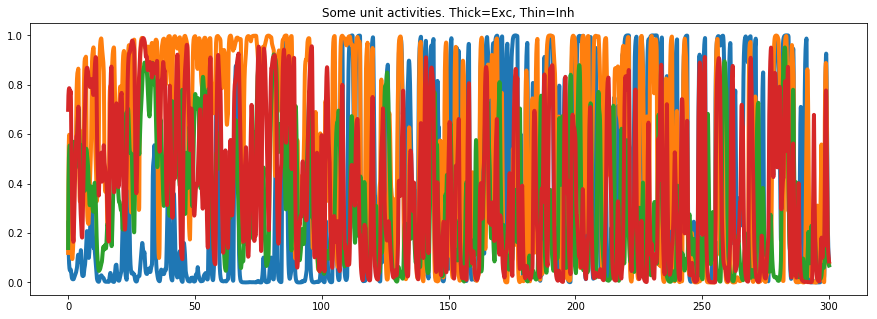

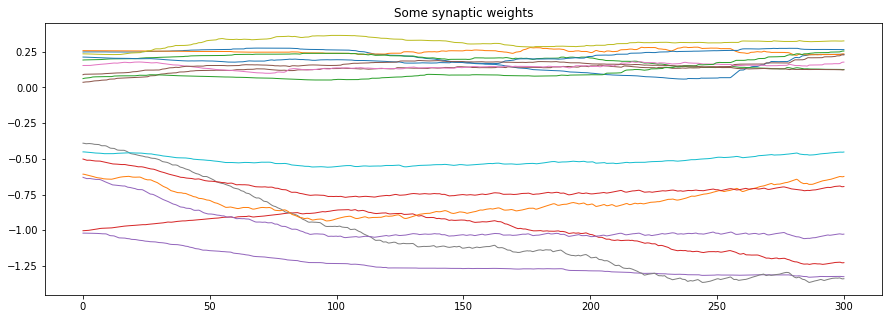

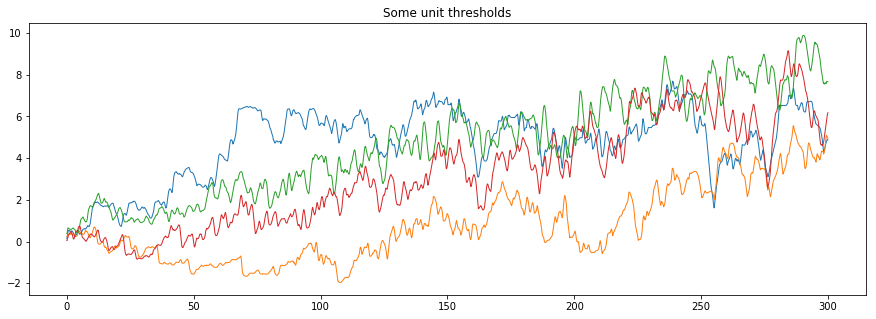

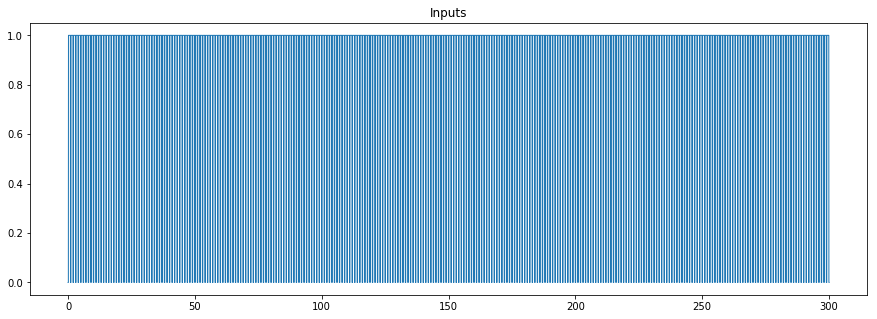

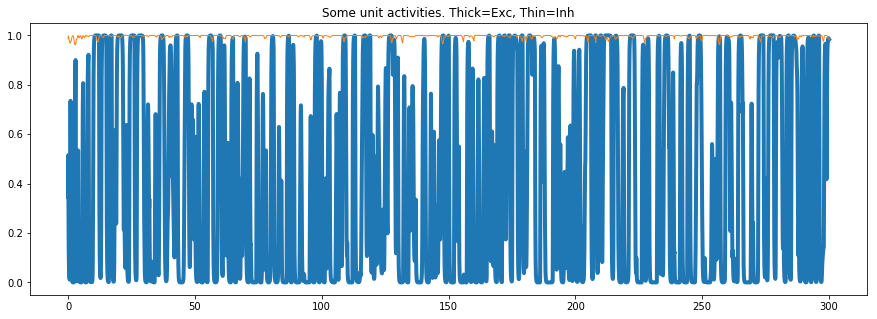

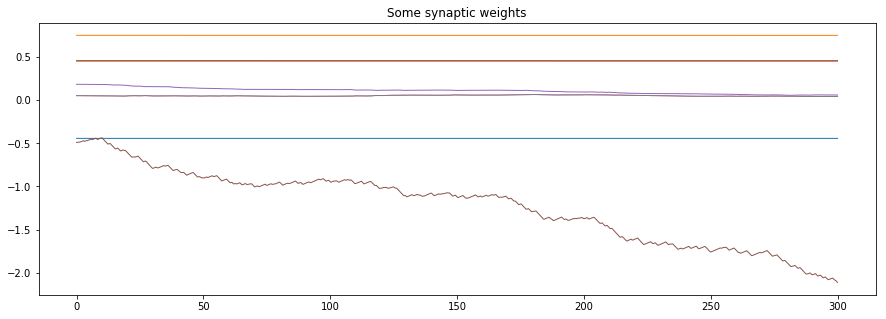

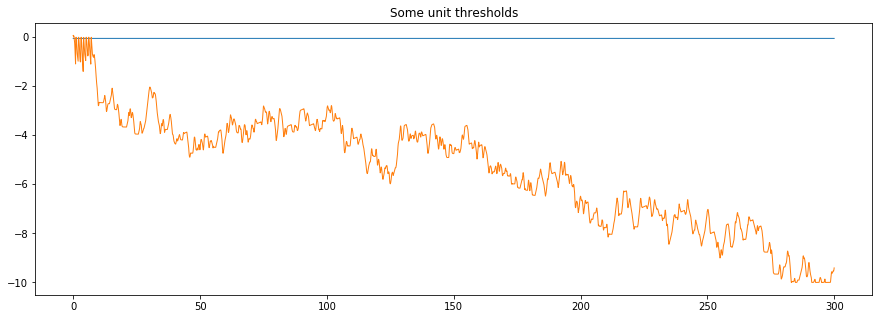

In [225]:
# basic plot 
%matplotlib inline
net_num = 7
net = mp_net_obj.nets[net_num]
L = net.layers['L']
LI3 = net.layers['LI3']
#shrp = net.layers['shrp']
I1 = net.layers['I1']
I2 = net.layers['I2']
I3 = net.layers['I3']
print(L.notes)
print(LI3.notes)
net.basic_plot('L')
net.basic_plot('LI3')

norm of output matrix: 68.302442
norm of input matrix: 68.718427
norm of difference between matrices: 8.972348


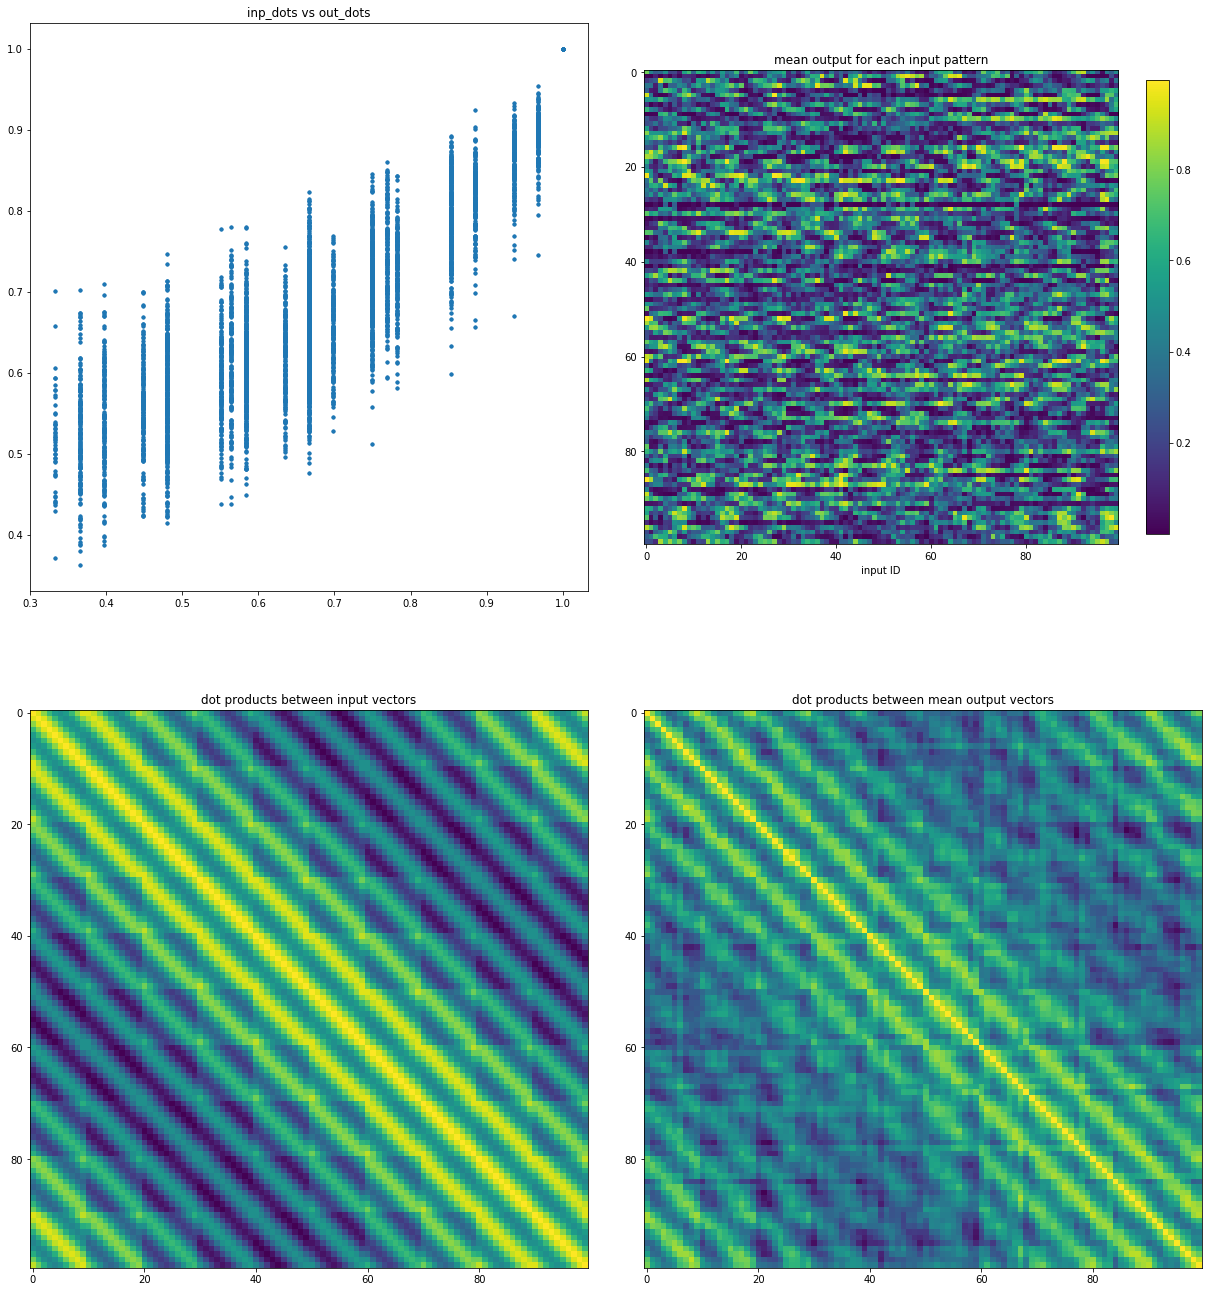

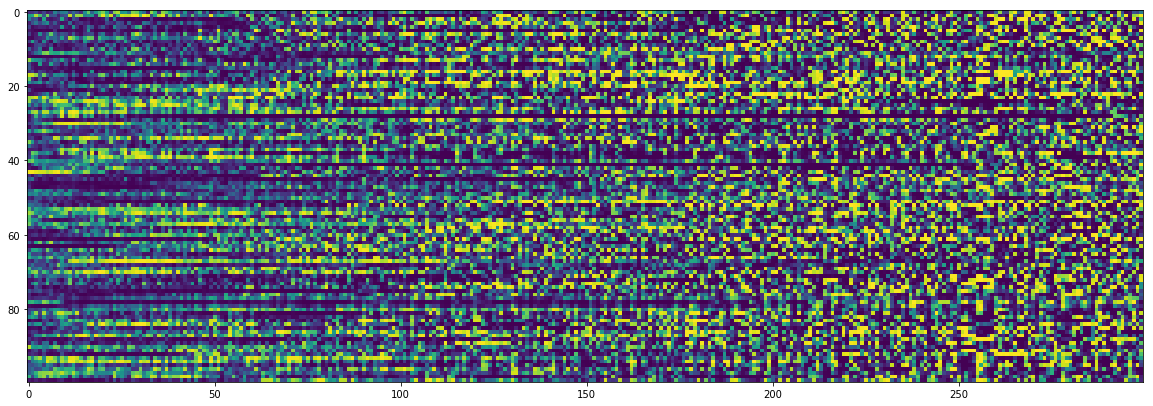

In [210]:
# input-output analysis
mp_net_obj.io_compare(net_num=net_num)

In [227]:
#net.double_anim(L.e, slider=False, interv=10, nbins=20, thr=0.7, pdf=True)
net.double_anim(L.e+LI3.e+I1.x+I2.x+I3.x, slider=False, interv=10, nbins=20, thr=0.7, pdf=True)

mean dot product is 0.828224, mean angle in degrees is 34.083295
mean norm of the difference: 1.035927, mean i3 norm: 1.919348, mean_li3 norm: 1.724774


Text(0.5,1,'dot products')

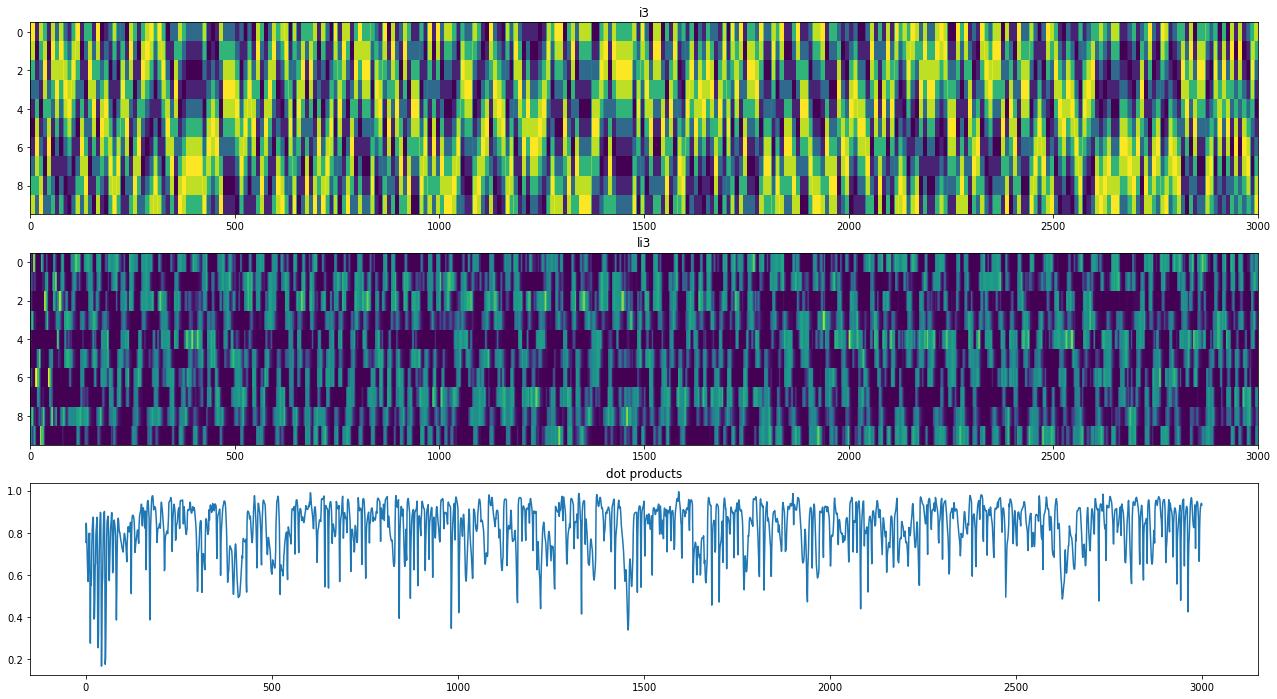

In [228]:
#### quantify the difference between I3 and LI3
start_time = 290. # time when the comparison starts
start_idx = int(np.floor(start_time/net.net.min_delay))
## Obtain a mean dot_product
# reduce the length of the activity vectors
jump = 20 # the analysis will sample 1 out of every 'jump' points
i3 = net.all_activs[I3.x][:,start_idx::jump] # taking 1 out of every 'jump' points
#i3 = net.all_activs[I3.x][:,::jump] # taking 1 out of every 'jump' points
li3 = net.all_activs[LI3.e][:,start_idx::jump]
#li3 = net.all_activs[LI3.e][:,::jump]
diff = i3 - li3 # used to obtain the mean norm of the difference
# normalizing all activity vectors
i3_norms = np.linalg.norm(i3, axis=0) + 1e-4
li3_norms = np.linalg.norm(li3, axis=0)
i3 = i3 / i3_norms
li3 = li3 / li3_norms
# obtaining all dot products
dots = np.sum(i3*li3, axis=0)
mean_dot = np.sum(dots) / len(dots)
mean_angle = np.arccos(mean_dot)
print("mean dot product is %f, mean angle in degrees is %f" %(mean_dot, mean_angle*180/3.141592))

## Obtain a mean norm of the difference
diff_nrm = np.linalg.norm(diff, axis=0)
mean_diff_nrm = np.mean(diff_nrm)
mean_i3_nrm = np.mean(i3_norms)
mean_li3_nrm = np.mean(li3_norms)
print("mean norm of the difference: %f, mean i3 norm: %f, mean_li3 norm: %f" %(mean_diff_nrm, mean_i3_nrm, mean_li3_nrm))
# random diff norm may be about 2/3

%matplotlib inline
fig, axes = plt.subplots(3,1, figsize=(22, 12))
im0 = axes[0].imshow(i3,aspect='auto')
axes[0].set_title('i3')
im1 = axes[1].imshow(li3,aspect='auto')
axes[1].set_title('li3')
pl = axes[2].plot(dots)
axes[2].set_title('dot products')        

In [ ]:
# Plot the highest excitatory unit activities (LI3)
%matplotlib inline
n_top = 6  # how many units to plot
top_pop = np.array(LI3.e)  # population to visualize
top_units = net.all_activs[top_pop].sum(1).argpartition(-n_top)[-n_top:]
print(top_units)
top_act_fig = plt.figure(figsize=(18,8))
top_acts = net.all_activs[top_pop[top_units]].transpose()
plt.plot(net.all_times, top_acts)
plt.show()

In [ ]:
# Plot the lowest excitatory unit activities
n_bottom = 5  # how many units to plot
bottom_pop = np.array(L.e)  # population to visualize
bottom_units = net.all_activs[bottom_pop].sum(1).argpartition(n_bottom)[0:n_bottom-1]
print(bottom_units)
bottom_act_fig = plt.figure(figsize=(18,8))
bottom_acts = net.all_activs[bottom_pop[bottom_units]].transpose()
plt.plot(net.all_times, bottom_acts)
plt.show()

In [ ]:
# Annotations for individual networks
net.annotate("This network is very good looking. In the mean output plot you can see units that have the ")
net.annotate("multiplicative modulation, and units that are modulated by a single input! But you can also see")
net.annotate("units that do not move much away from the 0.4 value, and outputs do not go beyond 0.8 .") 
#net.annotate("most responses are between 0.1 and 0.8 .")
#net.annotate("Did not look in detail, but it reminded me of multiplicative modulation.")
#net.annotate("with ei_runner_mp.", make_history=False)
#net.annotate("stop growing.", make_history=False)

In [ ]:
# Visualize the connections
#ei_net.conn_anim(I1.x+I2.x, L.e, slider=False)
net.conn_anim(L.e, L.e, slider=False)

In [ ]:
# Write the configuration of the mp_net_runner object in the simulation log
f = open(log_file, mode='a')
f.write(runner.stdout)
f.close()

In [ ]:
# log all networks
mp_net_obj.log() 

In [ ]:
# saving
for net in mp_net_obj.nets:
    net.history.append('ei_net object being saved in container mp_ei_runner object ' + mp_net_obj.name)
F = open(mp_net_obj.name+'.pkl', 'wb')
dill.dump(mp_net_obj, F)
F.close()

In [ ]:
# loading
#F = open("/media/z/data/pickles/exp_dist_sig_test4.pkl", 'rb')
#F = open("/home/z/projects/draculab/sig_ssrdc_test1.pkl", 'rb')
F = open("/home/z/projects/draculab/sig_trdc_test1.pkl", 'rb')
mp_net_obj = dill.load(F)

In [ ]:
mp_net_obj.code = str(runner)

In [ ]:
# Continue running after loading
mp_net_obj.run_all(save=True, log=False, save_interv=10)

In [ ]:
print(mp_net_obj.code)

In [ ]:
#~~~~~~~~~~~~ mp_net_runner object specification ~~~~~~~~~~~~

class mp_net_runner():
    """ A class to run several ei_network objects, each in a different process."""
    def __init__(self):
        """ Set parameter values and build the networks. 
        
            Parameters set:
            name : a name that describes how this version of mp_net_runner is being used.
            n_procs : number of processes to use.
            n_nets : number of networks that will be created.
            n_pres : n_pres[i] = number of input presentations for net 'i'
            pres_t : pres_t[i] = duration of each presentation for net 'i'
            input_type : The 'input_config' method, called by 'run_all', will specify the inputs sent by I1 and I2 in each
                         network, by creating custop inp_pats and inp_funcs methods. The value of input_type[i] is used in
                         input_config to know which input type will be used in network 'i'.
            inp_pats : inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config.
            inp_funcs : inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
            inp_hist1 : inp_hist1[i] = list with ID's of the inputs presented by layer I1 of network 'i'. 
            inp_hist2 : inp_hist2[i] = list with ID's of the inputs presented by layer I2 of network 'i'. 
        
        """
        self.name = 'exp_dist_sig_test4'  # a name that describes the use
        self.code = '' # to place the source code in the mp_net_runner class (e.g. this cell)
        self.n_procs = 12  # one per network is good
        self.n_nets = 12
        self.n_pres = [60]*self.n_nets # n_pres[i] = number of input presentations for net 'i'
        self.pres_t = [1.]*self.n_nets # pres_t[i] = duration of each presentation for net 'i'
        self.input_type = [1]*self.n_nets # specifies the values input_config assigns to inp_pats and inp_funcs
        self.inp_pats = [] # inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
        self.inp_funcs = [] # inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
        self.inp_hist1 = [[] for _ in range(self.n_nets)]  
        self.inp_hist2 = [[] for _ in range(self.n_nets)] 
        
        #F = open("/media/z/DATA/pickles/mp_net_runner_prototype.pkl", 'rb')
        #dill_obj = dill.load(F)
        #self.nets = dill_obj.nets
        
        layers =  ['L', 'shrp','I1', 'I2']  # L is the layer, shrp is for the sharpen port, I1,I2 are the input layers
        self.nets = [ei_network(layers, net_number=i) for i in range(self.n_nets)]
        
        # Setting the parameter changes for all networks
        ## First, set baseline changes
        for idx, net in enumerate(self.nets):
            net.annotate('This is network ' + str(idx) + ' in a run of an mp_net_runner object called ' + self.name)
            net.annotate('It is seeking good configurations for the sig_ssrdc units, based on step1p2 simulations. ')
            net.annotate('made on 10/13/18 .')
            #net.annotate('10x10 in L.e and 5x5 in L.i without compensating. In here the radius of connection')
            #net.annotate('is increased, the standard tau_scale is decreased, and in the variations to the homeostatic ')
        #----------------------------------
            L = net.layers['L']
            I1 = net.layers['I1']
            I2 = net.layers['I2']
        #----------------------------------
            L.annotate("Configuration of units in layer L.")
            L.set_param('e_pars', 'type', unit_types.sig_ssrdc)
            L.set_param('e_pars', 'slope_min', 1.7)
            L.set_param('e_pars', 'slope_wid', .5)
            L.set_param('e_pars', 'thresh_min', .0)
            L.set_param('e_pars', 'thresh_wid', 0.4)
            L.set_param('e_pars', 'n_ports', 2)
            L.set_param('e_pars', 'branch_params', {'branch_w' : [0.1, 0.45, 0.45], 'slopes' : 4, 'threshs' : 0.2})
            L.set_param('e_pars', 'tau_slow', 10.)
            L.set_param('e_pars', 'tau_fast', 0.05)
            L.set_param('e_pars', 'c', 3.)
            L.set_param('e_pars', 'tau_scale', .002)
            L.set_param('e_pars', 'Kp', .02)
            L.set_param('e_pars', 'tau_thr', .002)
            L.set_param('e_pars', 'rdc_port', 0)
            L.set_param('e_pars', 'thr_fix', 0.)
            L.set_param('e_pars', 'tau_fix', 0.1)
            L.set_param('e_pars', 'sharpen_port', 1)
        #----------------------------------
            L.annotate("Adjusting size of e,i groups.")
            L.set_param('e_geom', 'rows', 10)
            L.set_param('e_geom', 'columns', 10)
            L.set_param('i_geom', 'rows', 5)
            L.set_param('i_geom', 'columns', 5)
            L.set_param('e_geom', 'jitter', 0.)
            L.set_param('i_geom', 'jitter', 0.)
            L.annotate("Compensating for the ratio of excitatory to inhibitory units.")
            L.set_param('ee_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.3}})
            L.set_param('ei_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.3}})
            L.set_param('ie_conn', 'weights',{'uniform' : {'low': -1.2, 'high' : -.01}})            
            L.set_param('ii_conn', 'weights',{'uniform' : {'low': -1., 'high' : -0.01}})
        #----------------------------------
            L.annotate("Setting input parameters")
            L.set_param('x_geom', 'rows', 0) # no input units in layer L
        #-----------------------------------
            # specifying local input ports
            L.set_param('ee_syn', 'inp_ports', 0)
            L.set_param('ie_syn', 'inp_ports', 0)
        #----------------------------------
            L.annotate("Using Oja input synapses")
            L.set_param('xe_syn', 'type', synapse_types.oja)
            L.set_param('xe_syn', 'lrate', 1./100.)
            L.set_param('xi_syn', 'type', synapse_types.oja)
            L.set_param('xi_syn', 'lrate', 1./100.)
        #----------------------------------
            L.annotate("Using sq_hebbsnorm EE synapses")
            L.set_param('ee_syn', 'type', synapse_types.sq_hebbsnorm)
            L.set_param('ee_syn', 'lrate', 1./100.)
            L.set_param('ee_syn', 'omega', 2.)
        #----------------------------------
            L.annotate("Using corr_homeo_inhib IE synapses")
            L.set_param('ie_syn', 'type', synapse_types.corr_inh)
            L.set_param('ie_syn', 'lrate', 1./20.)
            L.set_param('e_pars', 'des_act', 0.2)
        #----------------------------------
            L.annotate("Using anti_cov_pre EI synapses")
            L.set_param('ei_syn', 'type', synapse_types.anticov_pre)
            L.set_param('ei_syn', 'lrate', .02)
        #----------------------------------
            I1.annotate("Configuration of I1 geometry")
            I1.set_param('e_geom', 'rows', 0)
            I1.set_param('i_geom', 'rows', 0)
            I1.set_param('x_geom', 'rows', 8)
            I1.set_param('x_geom', 'columns', 1)
            I1.set_param('x_geom', 'extent', [.5, 1.])
            I1.set_param('x_geom', 'center', [-.7, 0.])
        #----------------------------------
            I2.annotate("Configuration of I2 geometry")
            I2.set_param('e_geom', 'rows', 0)
            I2.set_param('i_geom', 'rows', 0)
            I2.set_param('x_geom', 'rows', 1)
            I2.set_param('x_geom', 'columns', 8)
            I2.set_param('x_geom', 'extent', [1., .5])
            I2.set_param('x_geom', 'center', [0., .7])
        #----------------------------------
            L.set_param('n', 'w_track', 16)
            I1.set_param('n', 'w_track', 0)
            I2.set_param('n', 'w_track', 0)
        #----------------------------------
        # Add interlayer connections
            net.add_connection(('I1','x'), ('L','e'))
            net.add_connection(('I1','x'), ('L','i'))
            net.add_connection(('I2','x'), ('L','e'))
            net.add_connection(('I2','x'), ('L','i'))
         #----------------------------------        
        # Configure interlayer connections
            net.set_param('I1x_Le_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I1x_Le_conn', 'kernel', 1.)
            net.set_param('I1x_Le_conn', 'weights', {'gaussian' : {'w_center': 1., 'sigma': .1}})
            net.set_param('I1x_Le_conn', 'dist_dim', 'y')
            net.set_param('I1x_Le_conn', 'edge_wrap', False)
            net.set_param('I1x_Le_syn', 'inp_ports', 1)

            net.set_param('I1x_Li_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I1x_Li_conn', 'kernel', 1.)
            net.set_param('I1x_Li_conn', 'weights', {'gaussian' : {'w_center': .3, 'sigma': 2.}})
            net.set_param('I1x_Li_conn', 'dist_dim', 'y')
            net.set_param('I1x_Li_conn', 'edge_wrap', False)

            net.set_param('I2x_Le_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I2x_Le_conn', 'kernel', 1.)
            net.set_param('I2x_Le_conn', 'weights', {'gaussian' : {'w_center': 1., 'sigma': .1}})
            net.set_param('I2x_Le_conn', 'edge_wrap', False)
            net.set_param('I2x_Le_conn', 'dist_dim', 'x')
            net.set_param('I2x_Le_syn', 'inp_ports', 1)

            net.set_param('I2x_Li_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I2x_Li_conn', 'kernel', 1.)
            net.set_param('I2x_Li_conn', 'weights', {'gaussian' : {'w_center': .3, 'sigma': 2.}})
            net.set_param('I2x_Li_conn', 'dist_dim', 'x')
            net.set_param('I2x_Li_conn', 'edge_wrap', False)
            
        # Now adjust networks individually
        ### network 0 is the baseline
        ### network 1
        n = 1
        L = self.nets[n].layers['L']
        L.annotate(">>> Smaller tau_scale")
        L.set_param('e_pars', 'tau_scale', .001)
        ### network 2
        n = 2
        L = self.nets[n].layers['L']
        L.annotate(">>> Smaller tau_scale, smaller Kp.")
        L.set_param('e_pars', 'tau_scale', 0.001)
        L.set_param('e_pars', 'Kp', 0.01)
        ### network 3
        n = 3
        L.annotate(">>> Smaller tau_scale, larger Kp.")
        L.set_param('e_pars', 'tau_scale', 0.001)
        L.set_param('e_pars', 'Kp', 0.05)
        ### Network 4
        n = 4
        L = self.nets[n].layers['L']
        L.annotate(">>> Larger tau_scale, smaller Kp.")
        L.set_param('e_pars', 'tau_scale', 0.005)
        L.set_param('e_pars', 'Kp', 0.01)
        ### Network 5
        n = 5
        L = self.nets[n].layers['L']
        L.annotate("Removing EI plasticity")
        L.set_param('ei_syn', 'type', synapse_types.static)
        ### Network 6
        n = 6
        L = self.nets[n].layers['L']
        L.annotate("Removing IE plasticity")
        L.set_param('ie_syn', 'type', synapse_types.static)
        ### Network 7
        n = 7
        L = self.nets[n].layers['L']
        L.annotate("Removing EE plasticity")
        L.set_param('ee_syn', 'type', synapse_types.static)
        ### Network 8
        n = 8
        L = self.nets[n].layers['L']
        L.annotate("Removing EI, IE plasticity")
        L.set_param('ei_syn', 'type', synapse_types.static)
        L.set_param('ie_syn', 'type', synapse_types.static)
        ### Network 9
        n = 9
        L = self.nets[n].layers['L']
        L.annotate("Removing EE, EI plasticity")
        L.set_param('ee_syn', 'type', synapse_types.static)
        L.set_param('ei_syn', 'type', synapse_types.static)
        ### Network 10
        n = 10
        L = self.nets[n].layers['L']
        L.annotate("Removing EE, IE plasticity")
        L.set_param('ee_syn', 'type', synapse_types.static)
        L.set_param('ie_syn', 'type', synapse_types.static)
        ### Network 11
        n = 11
        L = self.nets[n].layers['L']
        L.annotate("Removing EE, EI, IE plasticity")
        L.set_param('ee_syn', 'type', synapse_types.static)
        L.set_param('ei_syn', 'type', synapse_types.static)
        L.set_param('ie_syn', 'type', synapse_types.static)
        
        self.build()
                      
            
    def build(self):
        # Building the networks
        # The point of putting this outside the __init__ method is that if at some point the networks get too
        # big and take a long time to build, you can build them in parallel by creating a build(net_num)
        # method and then calling it from run_all with pool.map(build, range(self.n_nets))
        for net in self.nets:
            net.build()
         
    def inp_pat0(self, pres, rows, columns, net_id, port=0, random=True):
    # The function that creates the input pattern at L.x
        if random:
            idx = np.random.randint(4)
        else:
            idx = pres % 4
        return (self.pat_arr0[idx, :], idx)
    
    def inp_pat1(self, pres, rows, columns, net_id, n_pat, port=0, random=True):
        # A function to create input patterns for I1
        if random:
            idx = np.random.randint(n_pat)
        else:
            idx = pres % n_pat
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat)) for x in range(n_pat)], idx)

    def inp_pat2(self, pres, rows, columns, net_id, n_pat, port=0, random=True):
        # A function to create input patterns for I2
        if random:
            idx = np.random.randint(n_pat)
        else:
            idx = pres % n_pat
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat)) for x in range(n_pat)], idx)

    def make_I1_inp(self, n_pat, rnd):
        return lambda pres, rows, columns, net_id: self.inp_pat1(pres, rows, columns, net_id, n_pat, random=rnd) 
    
    def make_I2_inp(self, n_pat, rnd):
        return lambda pres, rows, columns, net_id: self.inp_pat2(pres, rows, columns, net_id, n_pat, random=rnd)

    def make_shrp_fun(self, prev_pat, cur_pat, init_time, pres_time, inp_units):
        eps = .1 # distance to the input change where sharpening is released
        return lambda t : 0. if (t < init_time+eps or t > init_time+pres_time-eps) else 1.
    
    def set_shrp_fun(self, pre_inp, cur_inp, init_time, pres_time, inp_units):
        for unit in inp_units:
            unit.set_function( self.make_shrp_fun(pre_inp, cur_inp, init_time, pres_time, inp_units) )
            
    def input_config(self):
        """ Populates the self.inp_pats, and self.inp_funcs lists used by run_net() to provide inputs.
        
            inp_pats[i] is the set_inp_pat dictionary given as an argument to ei_network.run for the i-th network.
            inp_funcs[i] is the set_inp_fun dictionary given as an argument to ei_network.run for the i-th network.
        """  
        # patterns for L.x
        n_pat0 = 4  # number of input patterns
        self.pat_arr0 = np.zeros((4, 25)) # ei_runner.n['x'])) # array with all input patterns
        for row in range(5):
            for col in range(5):
                idx = 5*col + row
                if row == col or row+col == 4: # The X input pattern
                    self.pat_arr0[0,idx] = 1
                if row == 2 or col == 2:  # The + input pattern
                    self.pat_arr0[1,idx] = 1
                if row == 1 or row == 3:  # The = input pattern
                    self.pat_arr0[2,idx] = 1
                if col == 1 or col == 3:  # The || input pattern
                    self.pat_arr0[3,idx] = 1
        self.pat_arr0 = self.pat_arr0 / 5.
        
        for idx, net in enumerate(self.nets):
            #L = net.layers['L']
            #shrp = net.layers['shrp']
            I1 = net.layers['I1']
            I2 = net.layers['I2']
            n_pat1 = I1.n['x']  # number of input patterns for I1 is number of input units
            n_pat2 = I2.n['x']  # number of input patterns for I2 is number of input units
            #pats1 = [] # here we'll store id's for the patterns presented by inp_pat1
            #pats2 = [] # here we'll store id's for the patterns presented by inp_pat2
            if self.input_type[idx] == 0:  # for sharpening units
                shrp_inp_pat = lambda p, r, c, n : (1., 1)
                inp_pat_dic = { 'I1' : self.make_I1_inp(n_pat1, True), 
                                'I2' : self.make_I2_inp(n_pat2, True), 
                                'shrp' : shrp_inp_pat }
                inp_fun_dic = {'shrp' : self.set_shrp_fun }
            elif self.input_type[idx] == 1: # for non-sharpening units
                inp_pat_dic = { #'L' : self.inp_pat0,
                                'I1' : self.make_I1_inp(n_pat1, True), 
                                'I2' : self.make_I2_inp(n_pat2, True) } 
                inp_fun_dic = {}
            else:
                raise ValueError('Invalid input type for network ' + str(idx))
            self.inp_pats.append(inp_pat_dic)
            self.inp_funcs.append(inp_fun_dic)

    def run_net(self, arg):
        net_num = arg[0]
        n_pres = arg[1]
        if n_pres > 0:
            print('Running network %d' % (net_num))
            return self.nets[net_num].run(n_pres, self.pres_t[net_num], self.inp_pats[net_num], self.inp_funcs[net_num])
        else: 
            return self.nets[net_num]
        
    def run_all(self, save=False, log=False, save_interv=10, pool=None):
        sys.setrecursionlimit(5000)  # otherwise the networks can't be pickled
        if pool == None:
            pool = ProcessingPool(nodes=self.n_procs) 
        self.input_config()  # configures the input functions
        print('Starting %d processes, %d networks' % (self.n_procs, self.n_nets))
        start_time = time.time()
        if save:
            run_sched = [ [] for _ in range(self.n_nets) ] # run_sched[i][j] = number of presentations in the j-th run
                                                           # of network i
            for idx in range(self.n_nets):
                base = int(np.floor(self.n_pres[idx]/save_interv))
                run_sched[idx] = [save_interv]*base 
                remainder = self.n_pres[idx]%save_interv
                if remainder > 0:
                    run_sched[idx].append(remainder)
            self.max_runs = max([len(sch) for sch in run_sched])
            run_sched = [sch + [0]*(self.max_runs-len(sch)) for sch in run_sched]
                    
            for run in range(self.max_runs):
                args = [(n, run_sched[n][run]) for n in range(self.n_nets)]
                self.nets = pool.map(self.run_net, args)
                for net in self.nets:
                    net.history.append('ei_network backup after run ' + str(run) + ' of mp_net_runner object ' + self.name)
                print("<><><><><> Backing up simulation after run " + str(run))
                F = open(self.name+'.pkl', 'wb')
                dill.dump(self, F)
                F.close()
        else:
            args = [(n, self.n_pres[n]) for n in range(n_nets)]
            self.nets = pool.map(self.run_net, args)
            # you can run just a few nets for debugging purposes...
            #selected = [0, 1, 2] #, 1, 2, 3, 6, 8, 9, 10, 11, 12, 14, 15]
            #sel_nets = [self.nets[n] for n in selected]
            #args = [(n, self.n_pres[n]) for n in selected]
            #sel_nets = pool.map(self.run_net, args)
            #for i,n in enumerate(selected):
            #    self.nets[n] = sel_nets[i]
                
        print('****** Processing finished after %s seconds ******' % (time.time() - start_time)) 
        pool.close()
        pool.join()
        
        if log:
            self.log()
                
    def log(self, file_name=log_file):
        for net in self.nets:
            net.log(file_name, params=(net.net_number == 0))                                                                
                                
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [ ]:
# Continue running after loading
mp_net_obj.run_all(save=True, log=False, save_interv=10)

In [ ]:
# Simulation analysis
net_num = 9
ei_net = mp_net_obj.nets[net_num]
pats1 = ei_net.inp_hist['I1']
pats2 = ei_net.inp_hist['I2']
n_pat1 = ei_net.layers['I1'].n['x']
n_pat2 = ei_net.layers['I2'].n['x']
pres_time = mp_net_obj.pres_t[net_num]
n_pres = mp_net_obj.nets[net_num].present
L = ei_net.layers['L']
inp_pat1 = mp_net_obj.make_I1_inp(n_pat1, False)
inp_pat2 = mp_net_obj.make_I2_inp(n_pat2, False)

## For each input presentation obtain the activity vector from layer L
ppat = int(round(pres_time/ei_net.net_params['min_delay'])) # number of data points per input pattern
pt = int(round((pres_time-0.2)/ei_net.net_params['min_delay'])) # data point where the vector will come from
e_pats = np.zeros((len(L.e), n_pres))  # array where we'll store the activity vectors
for pres in range(n_pres):
    for e_idx, idx in enumerate(L.e):
        e_pats[e_idx, pres] = ei_net.all_activs[idx, pres*ppat + pt]

# The ID of the input comes from the id's in pats1 and pats2, placed by inp_pat1 and inp_pat2 respectively.
pats = np.zeros(n_pat1*n_pat2)  # pats[n] is the number of times the pattern with ID 'n' appeared
n_pats = len(pats)
pres_pat = np.zeros(n_pres)  # pres_pat[n] is the ID of the pattern in presentation 'n'
for p in range(n_pres):
    p_id = n_pat2*pats1[p] + pats2[p] # the pattern ID 'flattens' all possible pairs of values
    pats[p_id] += 1
    pres_pat[p] = p_id
    
# plot the array of activity patterns
#%matplotlib inline
#ex_fig = plt.figure(figsize=(20,20))
#plt.imshow(e_pats)

# get the mean of output patterns corresponding to the same inputs
mean_out = np.zeros((len(L.e),n_pats)) # mean_out[:,n] = mean output for input n
for pres in range(n_pres):
    mean_out[:,int(pres_pat[pres])] += e_pats[:,pres]
    
for pat in range(n_pats):
    if pats[pat] > 1:
        mean_out[:, pat] = mean_out[:, pat]/ pats[pat]
        
# Obtain the angles between any two pairs of input patterns
# get all input patterns
all_inps = np.zeros((n_pats, n_pat1+n_pat2)) # all_inps[n,:] = input pattern with ID 'n'
for p1 in range(n_pat1):
    for p2 in range(n_pat2):
        (all_inps[p1*n_pat2+p2, :n_pat1], _) = inp_pat1(p1, 1, 1, net_num)
        (all_inps[p1*n_pat2+p2, n_pat1:], _) = inp_pat2(p2, 1, 1, net_num)
        

# get matrices with dot products between pairs of patterns
inp_norm = np.linalg.norm(all_inps[0,:])   # all input vectors have the same norm
inp_norm2 = inp_norm*inp_norm
inp_dots = np.zeros((n_pats, n_pats))
out_dots = np.zeros((n_pats, n_pats))
for p1 in range(n_pats):
    for p2 in range(n_pats):
        inp_dots[p1,p2] = np.dot(all_inps[p1,:], all_inps[p2,:])/inp_norm2
        if pats[p1] > 0 and pats[p2] > 0: # if the two input patterns were presented
                #pres_idx1 = np.argmin(abs(pres_pat - p1))  # index of presentation where you showed pattern 1
                #pres_idx2 = np.argmin(abs(pres_pat - p2))  # index of presentation where you showed pattern 2
                #vec1 = e_pats[:,pres_idx1]  # first input vector
                #vec2 = e_pats[:,pres_idx2]  # second input vector
                vec1 = mean_out[:,p1]
                vec2 = mean_out[:,p2]
                norm1 = np.linalg.norm(vec1)
                norm2 = np.linalg.norm(vec2)
                out_dots[p1,p2] = np.dot(vec1,vec2)/(norm1*norm2)

                
# compare the angles between input patterns with the angles between output patterns
absissae = []
ordinates = []
for row in range(n_pats):
    for column in range(n_pats):
        if out_dots[row,column] > 0:
            absissae.append(inp_dots[row,column])
            ordinates.append(out_dots[row,column])
            
#plot the results of the analysis
%matplotlib inline
fig, axes = plt.subplots(2,2, figsize=(21, 23))
fig.subplots_adjust(hspace=0.2, wspace=0.1)

im0 = axes[0,0].plot(absissae, ordinates, '.')
axes[0,0].set_title('inp_dots vs out_dots')
im1 = axes[0,1].imshow(mean_out)
axes[0,1].set_title('mean output for each input pattern')
fig.colorbar(im1,ax=axes[0,1],fraction=0.1,shrink=0.8)
im2 = axes[1,0].imshow(inp_dots)
axes[1,0].set_title('dot products between input vectors')
im3 = axes[1,1].imshow(out_dots)
axes[1,1].set_title('dot products between mean output vectors')
#fig.colorbar(im3,fraction=0.1,shrink=0.8)

fig2 = plt.figure(figsize=(20,10))
plt.imshow(e_pats)
plt.title('all runs')
    
# A numerical measure of how much the output representation differentiates the inputs may be the norm of (inp_dots - out_dots)
diff_norm = np.linalg.norm(inp_dots-out_dots) # will use Frobenius norm, as if they were vectors
print("norm of output matrix: %f" % (np.linalg.norm(out_dots)))
print("norm of input matrix: %f" % (np.linalg.norm(inp_dots)))
print("norm of difference between matrices: %f" % (diff_norm))

In [ ]:
# mean activity given the rate distribution
c = 3
a = np.exp(-c)
b = 1-a
mean = (b/c**3)*(1. - (c+1.)*a)
print(mean)

n_points = 1000
r = np.linspace(0.,1.,n_points)
pdf = (b/c)*np.exp(-c*r)
mean2 = np.dot(r,pdf)/n_points
print(mean2)

In [ ]:
for n in range(11):
    mp_net_obj.nets[n+1].log(log_file, False)

In [ ]:
log_file